In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)
sys.path.append(os.path.join(parent_folder_path, 'simulator'))
sys.path.append(os.path.join(parent_folder_path, 'equities/data_processing'))
# sys.path.append(os.path.join(parent_folder_path, 'tokenizer'))

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np
import pandas as pd
import random
import pickle as pkl
from typing import List, Tuple, Union
from copy import deepcopy
from tqdm import tqdm
from glob import glob
from datetime import datetime
from matplotlib import pyplot as plt
from contextlib import nullcontext
import torch
import time as pytime

from simulator.core import Message
from simulator.core.utils import str_to_ns, fmt_ts
from simulator.markets.order_book import OrderBook
from simulator.markets.orders import LimitOrder, Side, MarketOrder
from equities.data_processing import itch_preproc
from equities.data_processing import itch_encoding
# from equities.model import GPTConfig, GPT
from equities.fast_model import Transformer, ModelArgs
from equities.data_processing import itch_encoding

In [3]:
# INIT PARAMS
# -----------------------------------------------------------------------------
# init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
# out_dir = parent_folder_path + '/out' # ignored if init_from is not 'resume'
# checkpoint = parent_folder_path + '/out/ckpt.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v2.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v4.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v5.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v6.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v7.pt'

# checkpoint =  parent_folder_path + '/out/ckpt_pretrain_v1.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_pretrain_v2.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_pretrain_v3.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_pretrain_v4.pt'

# checkpoint =  parent_folder_path + '/out/ckpt_finetune_AAPL_v1.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_finetune_AAPL_v2.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_finetune_AAPL_v3.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_finetune_AAPL_v4.pt'

checkpoint =  parent_folder_path + '/out/ckpt_finetune_SPY_v1.pt'

# dataset = '12302019.NASDAQ_ITCH50_AAPL_message_proc.npy' # dataset to use for initial prompt
# start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
# msgs_to_load_LOB = 287500 # 10am # 15700 -> 9:30am # number of initial messages to load LOB with
msgs_to_load_LOB = 807000 # 12pm # number of initial messages to load dataset with
# num_context_msgs = 100 # 400 # number of messages from dataset to use as context
num_context_msgs = 300 # 400
# num_samples = 10 # number of samples to draw
num_samples = 1 # number of samples to draw (think of like monte carlo paths)
# max_new_tokens = 500 # number of tokens generated in each sample
max_new_tokens = 1 # number of tokens generated in each sample (think of like time steps)
# temperature = 1.015 # AAPL: 1.02 (best) # 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
temperature = 1.15 # SPY: 1.15 (best)
# top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
# top_k = 300 # 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
top_k = None
top_p = 0.98 # keep the top tokens with cumulative probability >= top_p (nucleus filtering)
# top_p = 0.98 # keep the top tokens with cumulative probability >= top_p (nucleus filtering)
assert 0.0 <= top_p <= 1.0
seed = 42 # * 2 # * 3 # + 200
vocab = itch_encoding.Vocab()
use_sink = True # if True, use a dedicated sink token at the start of every training sample (per https://arxiv.org/pdf/2309.17453.pdf)
use_bpe = False # True # if True, use byte pair encoding to encode the dataset
eom_token_val = 0 # vocab value for end-of-message token
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
quantize = False # quantize the model to int8
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


In [4]:
TIME = 0
WORLD_AGENT_ID = 1

class FakeExchangeAgent:
    def __init__(self):
        self.messages = []
        self.current_time = TIME
        self.mkt_open = TIME
        self.book_logging = None
        self.stream_history = 10

    def reset(self):
        self.messages = []

    def send_message(self, recipient_id: int, message: Message, _: int = 0):
        self.messages.append((recipient_id, message))

    def logEvent(self, *args, **kwargs):
        pass

In [5]:
# define load paths
# raw_itch_load_path = parent_folder_path + '/dataset/raw/ITCH/' # AAPL
raw_itch_load_path = '/media/hdd/data/ITCH/tmp/' # SPY

# processed_dataset = '03272019.NASDAQ_ITCH50_AAPL_message_proc.npy'
# eval_date = '03272019'
# processed_dataset = '12302019.NASDAQ_ITCH50_AAPL_message_proc.npy'
# eval_date = '12302019'
processed_dataset = '10302019.NASDAQ_ITCH50_SPY_message_proc.npy'
eval_date = '10302019'

# proc_data_dir = os.path.join('dataset/proc/ITCH/full_view/', processed_dataset)
proc_data_dir = os.path.join('dataset/proc/ITCH/multi/pre_train/full_view/', processed_dataset) # both AAPL and SPY

proc_data_dir = parent_folder_path + '/' + proc_data_dir

symbols_load_path = parent_folder_path + '/dataset/symbols/'
# symbols_file = sorted(glob(symbols_load_path + '*sp500*.txt'))[0]
symbols_file = sorted(glob(symbols_load_path + '*custom*.txt'))[0]

# locate raw ITCH data
# itch_message_files = sorted(glob(raw_itch_load_path + '*message*.csv')) # AAPL
# itch_book_files = sorted(glob(raw_itch_load_path + '*book*.csv')) # AAPL
itch_message_files = sorted(glob(raw_itch_load_path + '/messages/10302019/SPY/' + '*message*.csv'))
itch_book_files = sorted(glob(raw_itch_load_path + '/book/10302019/SPY/' + '*book*.csv'))
print('found', len(itch_message_files), 'ITCH message files')
print('found', len(itch_book_files), 'ITCH book files')

# create reverse ticker symbol mapping (key is index, value is ticker)
tickers = {}
with open(symbols_file) as f:
    idx = 0
    for line in f:
        idx += 1
        tickers[idx] = line.strip()

# load raw ITCH data (book)
symbols = []
for m_f, b_f in tqdm(zip(itch_message_files, itch_book_files)):
    if eval_date not in m_f:
        continue
    print(m_f)
    
    first_message = (itch_preproc.load_message_df(m_f)).iloc[0]

    # symbol to store in list and use to create OB objects in loop later
    symbol = m_f.rsplit('/', maxsplit=1)[-1][:-12].rsplit('_', maxsplit=1)[-1]
    print("Adding symbol:", symbol)
    symbols.append(symbol)

# load processed ITCH data (messages)
proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(msgs_to_load_LOB + num_context_msgs)])
print("proc_messages.shape:", proc_messages.shape)
# print("proc_messages:", proc_messages)
print([ "ticker", "order_id",
        "event_type", "direction", "price_abs", "price", "fill_size", "remain_size",
        "delta_t_s", "delta_t_ns", "time_s", "time_ns", "old_id",
        "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])

found 1 ITCH message files
found 1 ITCH book files


0it [00:00, ?it/s]

/media/hdd/data/ITCH/tmp//messages/10302019/SPY/10302019.NASDAQ_ITCH50_SPY_message.csv


/home/aaron/Documents/Github/MarketSimT/equities/data_processing/itch_preproc.py:55: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  messages = pd.read_csv(
1it [00:00,  1.94it/s]

Adding symbol: SPY
proc_messages.shape: (807300, 18)
['ticker', 'order_id', 'event_type', 'direction', 'price_abs', 'price', 'fill_size', 'remain_size', 'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns', 'old_id', 'price_ref', 'fill_size_ref', 'time_s_ref', 'time_ns_ref', 'old_price_abs']


In [6]:
print("Start time in hours:", ((proc_messages[-1][10] * 1000000000) + proc_messages[-1][11]) / 3600000000000)


Start time in hours: 12.133899793260278


In [7]:
print(proc_messages[-5:])
enc_msgs = itch_encoding.encode_msgs(proc_messages[-5:], vocab.ENCODING)
itch_encoding.decode_msgs(enc_msgs, vocab.ENCODING)

[[        5 133896092         4         1     30292         1        20
          0         0 179122829     43682     84500     -9999         1
         20     43681    103750     -9999]
 [        5 133904452         1         1     30291         0       100
      -9999         0  38964963     43682  39049463     -9999     -9999
      -9999     -9999     -9999     -9999]
 [        5 133904456         5         1     31201       911       100
      -9999         0     48932     43682  39098395 133896728        -1
        100     43681  32021414     31200]
 [        5 133904468         1         1     30291         1       200
      -9999         0     25104     43682  39123499     -9999     -9999
      -9999     -9999     -9999     -9999]
 [        5 133904488         1         1     30294         4       100
      -9999         0    132238     43682  39255737     -9999     -9999
      -9999     -9999     -9999     -9999]]


array([[        5,     -9999,         4,         1,     -9999,         1,
               20,         0,         0, 179122829,     43682,     84500,
            -9999,         1,        20,     43681,    103750,     -9999],
       [        5,     -9999,         1,         1,     -9999,         0,
              100,     -9999,         0,  38964963,     43682,  39049463,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [        5,     -9999,         5,         1,     -9999,       911,
              100,     -9999,         0,     48932,     43682,  39098395,
            -9999,        -1,       100,     43681,  32021414,     -9999],
       [        5,     -9999,         1,         1,     -9999,         1,
              200,     -9999,         0,     25104,     43682,  39123499,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [        5,     -9999,         1,         1,     -9999,         4,
              100,     -9999,     

In [8]:
# init new book under nasdaq agent
nasdaq_agent = FakeExchangeAgent()

# create a dictionary of order books based on each symbol in symbols
print("Creating order books for symbols:", symbols)
order_books = {}
for symbol in symbols:
    order_books[symbol] = OrderBook(nasdaq_agent, symbol)

# empty book
assert order_books[tickers[proc_messages[0][0]]].bids == order_books[tickers[proc_messages[0][0]]].asks == []

Creating order books for symbols: ['SPY']


In [9]:
# first message is missing in proc_messages, so we'll use the raw message file to start the book
print(first_message)

# insert bid order
bid_order = LimitOrder(
    order_id=first_message['id'],
    agent_id=1, # world agent, leave alone for now
    time_placed=first_message['time'],
    symbol=symbols[0],
    quantity=int(first_message['size']),
    side=Side.BID if first_message['side'] == 0 else Side.ASK,
    limit_price=int(first_message['price']*100),
)
order_books[symbols[0]].handle_limit_order(bid_order)

print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())
nasdaq_agent.messages

time        14400003215072
type                     A
id                    1008
side                     0
size                 300.0
price                302.6
cancSize               NaN
execSize               NaN
oldId                  NaN
oldSize                NaN
oldPrice               NaN
mpid                   NaN
Name: 0, dtype: object
L3 bid data: [(30260, [300])]
L3 ask data: []


[(1,
  OrderAcceptedMsg(message_id=1, order=(Agent 1 @ 1970-01-01 04:00:00) : BID 300 SPY @ $302.60))]

In [10]:
# INIT ORDER BOOKS FROM PROCESSED CONTEXT DATA

# [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]

# init variables to keep track of previous time, price, etc.
prev_time = first_message['time']
prev_price = int(first_message['price']*100)
L1 = [] # list to store L1 data for plotting
last_prices = [] # list to store last prices for plotting

# iterate through messages and update order books
for msg in proc_messages:
    # print(msg)
    symbol = tickers[msg[0]]
    # print("Symbol:", symbol)
    order_id = msg[1]
    # print("Order ID:", order_id)
    event_type = msg[2]
    # print("Event Type:", event_type)
    price = msg[4]
    # print("Price:", price)

    # verify time correctness
    assert prev_time + (msg[8]*1000000000) + msg[9] == (msg[10] * 1000000000) + msg[11]
    time = prev_time + (msg[8]*1000000000) + msg[9]
    # print("Time:", time)

    # handle order based on event type
    if event_type == 1:
        # ADD LIMIT ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].handle_limit_order(order)
    elif event_type == 2:
        # EXECUTE ORDER
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        order = MarketOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(order)
    elif event_type == 3:
        # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
        # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
        # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
        # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

        # modfify the matched limit order
        direction = Side.BID if msg[3] == 0 else Side.ASK
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order_size = msg[14]
        ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # define original order
        original_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=ref_order_time,
            symbol=symbol,
            quantity=ref_order_size,
            side=direction,
            limit_price=ref_order_price,
        )
        # define modified order
        # modified_price = msg[4]
        modified_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=ref_order_time,
            symbol=symbol,
            quantity=ref_order_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].modify_order(original_order, modified_order)
        # execute the modified order
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        order = MarketOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(order)
    elif event_type == 4:
        # CANCEL ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        if msg[7] == 0:
            # FULL DELETION
            fill_size = msg[6]
            # print("Cancel Size:", fill_size)
            order = LimitOrder(
                order_id=order_id,
                agent_id=1, # world agent, leave alone for now
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=fill_size,
                # quantity=msg[14], # total size of order when placed
                side=direction,
                limit_price=price,
            )
            order_books[symbol].cancel_order(order)
        else:
            # PARTIAL CANCELLATION
            cancel_size = msg[6]
            # print("Partial Cancel Size:", cancel_size)
            ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
            order = LimitOrder(
                order_id=order_id,
                agent_id=1, # world agent, leave alone for now
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=ref_order_size,
                side=direction,
                limit_price=price,
            )
            order_books[symbol].partial_cancel_order(order, cancel_size)
    elif event_type == 5:
        # REPLACE ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        old_order_id = msg[12]
        old_order_time = (msg[15] * 1000000000) + msg[16]
        old_order_size = msg[14]
        old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # define old order
        old_order = LimitOrder(
            order_id=old_order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=old_order_time,
            symbol=symbol,
            quantity=old_order_size,
            side=direction,
            limit_price=old_order_price,
        )
        new_order_size = msg[6]
        # define new order
        new_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=new_order_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].replace_order(1, old_order, new_order) # first arg is agent_id (world agent)
    else:
        raise NotImplementedError("Event type not implemented")

    # update previous time and price
    prev_time = time
    prev_price = price

    # update plotting variables
    L1.append((time, order_books[symbol].get_l1_bid_data(), order_books[symbol].get_l1_ask_data()))
    if event_type in [2, 3]:
        last_prices.append((time, price))
    
# print end result
# print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
# print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())
print("L2 bid data:", order_books[symbols[0]].get_l2_bid_data())
print("L2 ask data:", order_books[symbols[0]].get_l2_ask_data())

L2 bid data: [(30289, 3918), (30288, 1600), (30287, 1550), (30286, 3550), (30285, 3700), (30283, 7000), (30282, 2900), (30281, 3188), (30280, 2801), (30279, 3400), (30277, 4500), (30276, 3902), (30275, 2000), (30274, 2300), (30273, 300), (30272, 100), (30270, 1000), (30269, 200), (30267, 100), (30266, 100), (30264, 201), (30263, 100), (30258, 300), (30257, 201), (30255, 100), (30254, 453), (30251, 100), (30250, 390), (30249, 1), (30248, 300), (30245, 1), (30239, 202), (30237, 200), (30236, 100), (30235, 200), (30233, 200), (30232, 100), (30230, 151), (30225, 20), (30220, 141), (30218, 300), (30217, 100), (30210, 152), (30202, 200), (30201, 2500), (30200, 875), (30199, 10), (30198, 287), (30197, 100), (30195, 301), (30189, 701), (30185, 100), (30182, 850), (30181, 100), (30180, 601), (30175, 400), (30172, 100), (30170, 351), (30166, 100), (30164, 5), (30162, 100), (30161, 7), (30160, 2), (30152, 100), (30150, 701), (30149, 2), (30139, 1), (30130, 101), (30125, 5105), (30120, 301), (3011

len(L1): 807300


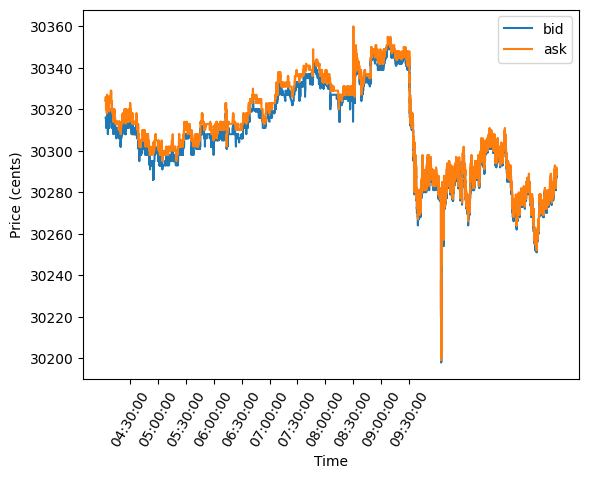

In [11]:
print("len(L1):", len(L1))

# plot L1 data
times = [L1[i][0] for i in range(len(L1))]
bids = [L1[i][1][0] for i in range(len(L1))]
asks = [L1[i][2][0] for i in range(len(L1))]
# plt.plot(times, bids, label='bid')
# plt.plot(times, asks, label='ask')

# plot recent time steps
# plt.plot(times[-14000:], bids[-14000:], label='bid')
# # plt.plot(times[-14000:], asks[-14000:], label='ask')

# plt.plot(times[-286000:], bids[-286000:], label='bid')
# plt.plot(times[-286000:], asks[-286000:], label='ask')
# plt.plot(times[-286600:], bids[-286600:], label='bid')
# plt.plot(times[-286600:], asks[-286600:], label='ask')
plt.plot(times[900:], bids[900:], label='bid')
plt.plot(times[900:], asks[900:], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
# plt.show()

time_mesh = np.arange(
    str_to_ns("04:30:00"),
    # str_to_ns("09:30:00"),
    str_to_ns("10:00:00"),
    1e9*60*30 # last number is minutes increment (every 30 minutes in this case)
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [12]:
# plt.style.use('dark_background')
# plt.rc('axes', axisbelow=True)

# print("len(L1):", len(L1))

# # plot L1 data
# times = [L1[i][0] for i in range(len(L1))]
# bids = [L1[i][1][0] for i in range(len(L1))]
# asks = [L1[i][2][0] for i in range(len(L1))]
# # plt.plot(times, bids, label='bid')
# # plt.plot(times, asks, label='ask')

# # convert to dollars
# bids = [(bid / 100) for bid in bids]
# asks = [(ask / 100) for ask in asks]

# # plot recent time steps
# # plt.plot(times[-14000:], bids[-14000:], label='bid')
# # # plt.plot(times[-14000:], asks[-14000:], label='ask')

# plt_t = 286600 - 5000
# plt.plot(times[-plt_t:], bids[-plt_t:], label='bid', color='blue')
# plt.plot(times[-plt_t:], asks[-plt_t:], label='ask', color='red')

# # # plot raw logits
# # plt.scatter(range(raw_logits[plt_pos].shape[1]), raw_logits[plt_pos].cpu(), s=1, color='red')
# # plt.xlabel("Vocab Index", fontsize=12)
# # plt.ylabel("Logit Value", fontsize=12)
# # plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
# # # save the plot
# # plt.savefig(f'{parent_folder_path}/fig/sample_logits.pdf', bbox_inches='tight')

# plt.legend()
# plt.xlabel("Time", fontsize=12)
# plt.ylabel("Price", fontsize=12)
# plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# # plt.show()

# time_mesh = np.arange(
#     # str_to_ns("04:30:00"),
#     str_to_ns("09:00:00"),
#     # str_to_ns("09:30:00"),
#     str_to_ns("10:01:00"),
#     1e9*60*10 # last number is minutes increment (every 30 minutes in this case)
# )
# _=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

# # save the plot
# plt.savefig(f'{parent_folder_path}/fig/pregen_bidask.pdf', bbox_inches='tight')

len(last_prices): 23020


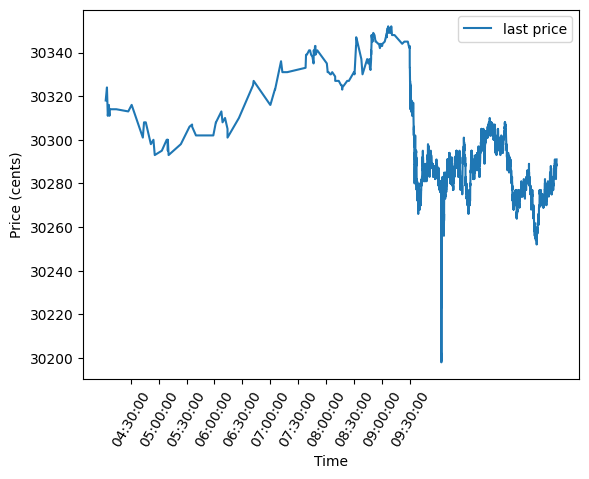

In [13]:
print("len(last_prices):", len(last_prices))

# plot last prices
times = [last_prices[i][0] for i in range(len(last_prices))]
prices = [last_prices[i][1] for i in range(len(last_prices))]
plt.plot(times, prices, label='last price')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
# plt.show()

time_mesh = np.arange(
    str_to_ns("04:30:00"),
    # str_to_ns("09:30:00"),
    str_to_ns("10:00:00"),
    1e9*60*30 # last number is minutes increment (every 30 minutes in this case)
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

# TODO: put in *-minute buckets plot series

In [14]:
# # INIT MODEL
# if init_from == 'resume':
#     # init from a model saved in a specific directory
#     ckpt_path = os.path.join(out_dir, 'ckpt.pt')
#     checkpoint = torch.load(ckpt_path, map_location=device)
#     gptconf = GPTConfig(**checkpoint['model_args'])
#     model = GPT(gptconf)
#     state_dict = checkpoint['model']
#     unwanted_prefix = '_orig_mod.'
#     for k,v in list(state_dict.items()):
#         if k.startswith(unwanted_prefix):
#             state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
#     model.load_state_dict(state_dict)

# INIT MODEL
# init from a model saved in a specific directory
checkpoint_dict = torch.load(checkpoint, map_location=device)
gptconf = ModelArgs(**checkpoint_dict['model_args'])
model = Transformer(gptconf)
state_dict = checkpoint_dict['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)

# # free up memory
# del v
# torch.cuda.empty_cache()

if quantize: # Note: this doesn't work with GPU-trained models (i.e., it's useless)
    model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)

model.eval()
model.to(device)

number of parameters: 94.29M


Transformer(
  (tok_embeddings): Embedding(12160, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=768, out_features=768, bias=False)
        (wk): Linear(in_features=768, out_features=768, bias=False)
        (wv): Linear(in_features=768, out_features=768, bias=False)
        (wo): Linear(in_features=768, out_features=768, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=768, out_features=2048, bias=False)
        (w2): Linear(in_features=2048, out_features=768, bias=False)
        (w3): Linear(in_features=768, out_features=2048, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=76

In [15]:
# encode the context data
X_raw = proc_messages[-num_context_msgs:] # take the last 'num_context_msgs' messages as context
print("X_raw.shape:", X_raw.shape)
print("X_raw:", X_raw)
print("X_raw (last msg):", X_raw[-1])
X = itch_encoding.encode_msgs(X_raw, vocab.ENCODING)
print("X.shape:", X.shape)
print("X:", X)
# ex. decode the context data (will be missing order id, price_abs, old_id, and old_price_abs)
print("decoded X (last msg):", itch_encoding.decode_msg(X[-1], vocab.ENCODING))
time = itch_encoding.decode_msg(X[-1], vocab.ENCODING)[10] * 1000000000 + itch_encoding.decode_msg(X[-1], vocab.ENCODING)[11]
print("starting simulation time:", time)
gen_start_time = time # for computing simulation time elapsed in generation

encoded_tok_len = X.shape[1]
print("encoded_tok_len:", encoded_tok_len)

# prepare context tensor
if use_bpe:
    # load the tokenizer
    # bpe_tok_path = parent_folder_path + '/tokenizer/bpe_tokenizer.pkl'
    bpe_tok_path = parent_folder_path + '/tokenizer/bpe_tokenizer_pretrain.pkl'
    with open(bpe_tok_path, 'rb') as f:
        bpe_tokenizer = pkl.load(f)
    # bpe encode the messages and concat EOM token to the end
    bpe_encoded = []
    for msg in range(len(X)):
        bpe_encoded = bpe_encoded + bpe_tokenizer.bpe_encode(X[msg]) + [eom_token_val]
    # convert to tensor, unsqueeze to add batch dimension
    x = torch.tensor(bpe_encoded, dtype=torch.long, device=device).unsqueeze(0)
else:
    x = (torch.tensor(X.reshape(-1), dtype=torch.long, device=device)[None, ...])

if use_sink:
    # append sink token to start of each batch sequence (since vocab.SINK_TOK = 1, we can just use torch.ones)
    assert vocab.SINK_TOK == 1
    x = torch.cat([torch.ones((1, 1), dtype=torch.long, device=device), x], dim=1)
print("x.shape:", x.shape)
print("x:", x)

X_raw.shape: (300, 18)
X_raw: [[        5 133853032         4 ...     43676 409028950     -9999]
 [        5 133857192         1 ...     -9999     -9999     -9999]
 [        5 133857196         1 ...     -9999     -9999     -9999]
 ...
 [        5 133904456         5 ...     43681  32021414     31200]
 [        5 133904468         1 ...     -9999     -9999     -9999]
 [        5 133904488         1 ...     -9999     -9999     -9999]]
X_raw (last msg): [        5 133904488         1         1     30294         4       100
     -9999         0    132238     43682  39255737     -9999     -9999
     -9999     -9999     -9999     -9999]
X.shape: (300, 24)
X: [[12016  1006 12010 ...   412    31   953]
 [12016  1003 12010 ...     2     2     2]
 [12016  1003 12011 ...     2     2     2]
 ...
 [12016  1007 12011 ...    35    24   417]
 [12016  1003 12011 ...     2     2     2]
 [12016  1003 12011 ...     2     2     2]]
decoded X (last msg): [       5    -9999        1        1    -9999       

In [16]:
exact_match = 0
size_only_match = 0
time_only_match = 0
no_match = 0

matching_method = {}
matching_method['exact_match'] = 0
matching_method['size_only_match'] = 0
matching_method['time_only_match'] = 0
matching_method['no_match'] = 0

In [17]:
def find_matching_order(order_book: OrderBook, direction: Side, price: int, fill_size: int, ref_order_time: int, matching_method: dict) -> LimitOrder:
    # Error correction: find matching order in order book or re-run timestep if None
    book = order_book.bids if direction.is_bid() else order_book.asks

    for i, price_level in enumerate(book):
        if not price_level.price == price:
            continue

        # print("price match found at level:", i)
        # print("orders at this price level:", price_level.visible_orders)

        # compile candidate orders
        candidate_orders = []
        for order in price_level.visible_orders:
            # print("order:", order[0])
            candidate_orders.append(order[0]) if order[0].agent_id == WORLD_AGENT_ID else None

        # find matching order
        # print("candidate orders:", candidate_orders)
        candidiate_size_only = []
        candidiate_time_only = []
        for order in candidate_orders:
            if order.quantity == fill_size and order.time_placed == ref_order_time:
                # print("matching order (size & time) found:", order)
                matching_method['exact_match'] += 1
                return deepcopy(order)
            elif order.quantity == fill_size and order.time_placed != ref_order_time:
                # print("matching order (size only) found:", order)
                candidiate_size_only.append(order)
                matching_method['size_only_match'] += 1
            elif order.quantity != fill_size and order.time_placed == ref_order_time:
                # print("matching order (time only) found:", order)
                candidiate_time_only.append(order)
                matching_method['time_only_match'] += 1
            # else:
                # print("no matching order found")

        if len(candidiate_size_only) >= 1:
            # print("return matching order (size only):", candidiate_size_only[0])
            return deepcopy(candidiate_size_only[0])
        elif len(candidiate_time_only) >= 1:
            # print("return matching order (time only):", candidiate_time_only[0])
            return deepcopy(candidiate_time_only[0])
        elif len(candidate_orders) >= 1:
            # print("no matching order found. Return initial volume at price level:", candidate_orders[0])
            matching_method['no_match'] += 1
            return deepcopy(candidate_orders[0])

    # throw error if no match found
    # raise ValueError("No matching order found in order book")
    return None

In [18]:
def process_message(
        symbol: str,
        price: int,
        time: int,
        event_type: int,
        msg: np.ndarray,
        order_books: dict,
        agent_id: int = 1, # world agent by default
        matching_method: dict = None, # dict to store matching method counts
# ) -> Union[LimitOrder, MarketOrder, Tuple[LimitOrder, LimitOrder], None]:
):
    """Handles ITCH message processing and order book updates.

    Arguments:
        price (int): Price of order.
        time (int): Time of order.
        event_type (int): Type of event.
        msg (np.ndarray): ITCH message.
        order_book (OrderBook): Order book object.
    """

    # handle message based on event type
    if event_type == 1:
        # ADD LIMIT ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        new_order = LimitOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].handle_limit_order(new_order)
        ref_order = None
    elif event_type == 2:
        # EXECUTE ORDER
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        new_order = MarketOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(new_order)
        ref_order = None
    elif event_type == 3:
        # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
        # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
        # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
        # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

        # modfify the matched limit order
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # This is a reference order type, so we must undergo the error correction procedure
        # get reference order details
        bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
        mid_price = ((bid_price + ask_price) / 2) // 1
        ref_price = int(mid_price) + msg[13]
        ref_size = msg[14]
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order = find_matching_order(order_books[symbol], direction, ref_price, ref_size, ref_order_time, matching_method)
        if ref_order is None:
            return None, None
        # define modified order
        modified_order = LimitOrder(
            agent_id=agent_id,
            time_placed=ref_order.time_placed,
            symbol=symbol,
            quantity=ref_order.quantity,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].modify_order(ref_order, modified_order)
        # execute the modified order
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        new_order = MarketOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(new_order)
    elif event_type == 4:
        # CANCEL ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        if msg[7] == 0:
            # FULL DELETION
            fill_size = msg[6]
            # print("Cancel Size:", fill_size)
            # This is a reference order type, so we must undergo the error correction procedure
            ref_order = find_matching_order(order_books[symbol], direction, price, fill_size, ref_order_time, matching_method)
            if ref_order is None:
                return None, None
            order_books[symbol].cancel_order(ref_order)
            new_order = None
        else:
            # PARTIAL CANCELLATION
            cancel_size = msg[6]
            # print("Partial Cancel Size:", cancel_size)
            ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
            # This is a reference order type, so we must undergo the error correction procedure
            ref_order = find_matching_order(order_books[symbol], direction, price, ref_order_size, ref_order_time, matching_method)
            if ref_order is None:
                return None, None
            if ref_order.quantity is not ref_order_size:
                # preserve intent of generated partial cancel order
                cancel_ratio = cancel_size / ref_order_size
                cancel_size = int(ref_order.quantity * cancel_ratio)
            order_books[symbol].partial_cancel_order(ref_order, cancel_size)
            # make dummy order to track new cancel_size
            new_order = LimitOrder(
                order_id=-1,
                agent_id=agent_id,
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=cancel_size, # partial cancel size
                side=direction,
                limit_price=0,
            )
    elif event_type == 5:
        # REPLACE ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        # This is a reference order type, so we must undergo the error correction procedure
        # get reference order details
        bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
        mid_price = ((bid_price + ask_price) / 2) // 1
        ref_price = int(mid_price) + msg[13]
        ref_size = msg[14]
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order = find_matching_order(order_books[symbol], direction, ref_price, ref_size, ref_order_time, matching_method)
        if ref_order is None:
            return None, None
        # define new order
        fill_size = msg[6]
        new_order = LimitOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].replace_order(agent_id, ref_order, new_order)
    else:
        raise NotImplementedError(f"Event type {event_type} not implemented")
    
    # return order object for next message encoding step
    return new_order, ref_order

In [19]:
x[0][-22:]

tensor([12011, 12009, 11012,  1108,     2,     3,     3,   135,   241,    46,
          685,    42,   258,   740,     2,     2,     2,     2,     2,     2,
            2,     2], device='cuda:0')

In [20]:
# # top_k = None
# print("x.shape:", x.shape)
# print("x:", x)
# print("temperature:", temperature)
# print("top_k:", top_k)
# print("top_p:", top_p)

# from torch.nn import functional as F

# idx = x
# B,T = idx.shape
# input_pos = idx.shape[1] - 1
# KVCACHE = True
# start = True # False
# roll = False
# new_block_size = 2688
# vocab_encoding = vocab.ENCODING
# use_relevant_mask = True


# raw_logits = []
# # for tok_pos in range(encoded_tok_len):
# for tok_pos in range(13):
#     print(f"tok_pos: {tok_pos}")
#     # if the sequence context is growing too long we must crop it at block_size
#     idx_cond = idx # if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
#     # forward the model to get the logits for the index in the sequence
#     if KVCACHE and not start:
#         x_idx = idx_cond[:,-1].reshape(-1,1)
#     else:
#         x_idx = idx_cond
#         input_pos = 0
#     # print("input_pos:", input_pos)
#     # print("x_idx.shape:", x_idx.shape)
#     logits = model.forward(x_idx, None, kv_cache=KVCACHE, max_seq_length=new_block_size, input_pos=input_pos, roll=roll)
#     # print("logits.shape:", logits.shape)
#     logits = logits[:, -1, :] # crop to just the final time step
#     # print("logits.shape:", logits.shape)
#     # print("logits:", logits)

#     if temperature == 0.0: # greedy sampling:
#         # "sample" the single most likely index
#         _, idx_next = torch.topk(logits, k=1, dim=-1)
#     else:
#         # pluck the logits at the final step and scale by desired temperature
#         logits = logits / temperature
#         raw_logits.append(logits.clone().detach()) #### for plotting
#         # optionally crop the logits to only the top k options
#         if top_k is not None:
#             v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#             logits[logits < v[:, [-1]]] = -float('Inf')
#         if top_p > 0.0:
#             # First sort and calculate cumulative sum of probabilities.
#             sorted_logits, sorted_indices = torch.sort(logits, descending=False)
#             cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
#             # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
#             sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
#             # scatter sorted tensors to original indexing
#             indices_to_remove = sorted_indices_to_remove.scatter(
#                 1, sorted_indices, sorted_indices_to_remove
#             )
#             logits.masked_fill_(indices_to_remove, float("-inf")) # masks all positions in indices_to_remove that are True
#         # apply softmax to convert logits to (normalized) probabilities
#         probs = F.softmax(logits, dim=-1)
#         idx_next = torch.multinomial(probs, num_samples=1)
#     # print("idx_next.shape:", idx_next.shape)
#     print("idx_next:", idx_next)
#     input_pos = idx.shape[1]
#     start = False
#     roll = False
#     # append sampled index to the running sequence and continue
#     idx = torch.cat((idx, idx_next), dim=1)
#     if idx_next[0].item() == eom_token_val:
#         print("End of message token found. Ending generation.")
#         break

# # raw_logits = []
# # relevant_logits = []

# # for tok_pos in range(encoded_tok_len):
# #     print(f"tok_pos: {tok_pos}")
# #     # if the sequence context is growing too long we must crop it at block_size
# #     idx_cond = idx # if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
# #     # forward the model to get the logits for the index in the sequence
# #     if KVCACHE and not start:
# #         x_idx = idx_cond[:,-1].reshape(-1,1)
# #     else:
# #         x_idx = idx_cond
# #         input_pos = 0
# #     # print("input_pos:", input_pos)
# #     # print("x_idx.shape:", x_idx.shape)
# #     logits = model.forward(x_idx, None, kv_cache=KVCACHE, max_seq_length=new_block_size, input_pos=input_pos, roll=roll)
# #     # print("logits.shape:", logits.shape)
# #     logits = logits[:, -1, :] # crop to just the final time step
#     # print("logits.shape:", logits.shape)
#     # print("logits:", logits)

# #     if temperature == 0.0: # greedy sampling:
# #         # "sample" the single most likely index
# #         _, idx_next = torch.topk(logits, k=1, dim=-1)
# #     else:
# #         # pluck the logits at the final step and scale by desired temperature
# #         logits = logits / temperature
# #         raw_logits.append(logits.clone().detach()) #### for plotting
# #         # optionally mask indices that are not relevant for the current token field
# #         if use_relevant_mask:
# #             logits = relevant_mask(tok_pos, logits, vocab_encoding, logits.device)
# #             relevant_logits.append(logits.clone().detach()) #### for plotting
# #         # optionally crop the logits to only the top k options
# #         if top_k is not None:
# #             v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
# #             logits[logits < v[:, [-1]]] = -float('Inf')
# #         if top_p > 0.0:
# #             # First sort and calculate cumulative sum of probabilities.
# #             sorted_logits, sorted_indices = torch.sort(logits, descending=False)
# #             cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
# #             # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
# #             sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
# #             # scatter sorted tensors to original indexing
# #             indices_to_remove = sorted_indices_to_remove.scatter(
# #                 1, sorted_indices, sorted_indices_to_remove
# #             )
# #             logits.masked_fill_(indices_to_remove, float("-inf")) # masks all positions in indices_to_remove that are True
# #         # apply softmax to convert logits to (normalized) probabilities
# #         probs = F.softmax(logits, dim=-1)
# #         idx_next = torch.multinomial(probs, num_samples=1)
# #     # print("idx_next.shape:", idx_next.shape)
# #     print("idx_next:", idx_next)
# #     input_pos = idx.shape[1]
# #     start = False
# #     roll = False
# #     # append sampled index to the running sequence and continue
# #     idx = torch.cat((idx, idx_next), dim=1)

# # print("msg:", idx[0][-24:].tolist())

In [21]:
# idx, tok_pos

# idx[0][-(tok_pos+1):].cpu().detach().numpy()

# # decode the BPE tokens
# decoded_bpe = bpe_tokenizer.bpe_decode(idx[0][-(tok_pos+1):].cpu().detach().numpy(), vocab)
# print("decoded_bpe:", decoded_bpe)

# # decode the tokens back to the original message
# decoded_msg = itch_encoding.decode_msg(np.array(decoded_bpe[-25:-1]), vocab.ENCODING)
# print(decoded_msg)

In [22]:
# # decoded_msg

# x_new = itch_encoding.encode_msg(decoded_msg, vocab.ENCODING)

# x_new

# # bpe encode x_new
# # bpe_tokenizer.bpe_encode(x_new) + [eom_token_val]
# # bpe_encoded = bpe_tokenizer.bpe_encode(x_new) + [eom_token_val]

# # # concat x_new and eom_token_val
# # # np.concatenate((x_new, [eom_token_val]))

# # encode the new message and convert to torch tensor
# x_new = itch_encoding.encode_msg(decoded_msg, vocab.ENCODING)
# if use_bpe:
#     # x_new = np.concatenate((x_new, [eom_token_val]))
#     x_new = bpe_tokenizer.bpe_encode(x_new) + [eom_token_val]
# x_new = torch.tensor(x_new, dtype=torch.long, device=device)
# x_new = torch.unsqueeze(x_new, 0) # add batch dimension for concatenation purposes

# x_new

In [23]:
# logits
# probs

# # plot probs
# # plt.plot(probs.cpu().detach().numpy())
# plt_pos = 0
# plt.scatter(range(raw_logits[plt_pos].shape[1]), raw_logits[plt_pos].cpu(), s=1, color='red')


In [24]:
num_generation_steps = (5000 * 6) * 5 # * 12 # * 5
num_errors = 0
num_sampling_errors = 0
num_symbol_errors = 0
num_time_errors = 0
num_ref_errors = 0
rolling_error_count = 0
order_placement_error_list = []
L1_gen = []
last_prices_gen = []
gen_msgs = []
num_add_order_msgs = 0
num_exec_order_msgs = 0
num_execmod_order_msgs = 0
num_full_cancel_order_msgs = 0
num_partial_cancel_order_msgs = 0
num_replace_order_msgs = 0
start = True
roll = False
roll_len = 0
clock_start_time = pytime.time()
# block_size = model.config.block_size
# block_size = model.params.max_seq_len
new_block_size = 10344 # 2688 # 10344 # 2688 # 112 msgs # 10344 # 431 msgs # use this param to shorten block size for faster generation

In [25]:
for t in tqdm(range(num_generation_steps)):
# for t in tqdm(range(3000)):
# for t in range(num_generation_steps):
    # run generation
    with torch.no_grad():
        with ctx:
            # for k in range(num_samples):
            if not use_bpe:
                y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature,
                                   top_k=top_k, top_p=top_p, start=start, roll=roll,
                                   new_block_size=new_block_size, vocab_encoding=vocab.ENCODING)
            else:
                y, tok_pos = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature,
                                   top_k=top_k, top_p=top_p, start=start, roll=roll,
                                   new_block_size=new_block_size, vocab_encoding=vocab.ENCODING,
                                   use_bpe=use_bpe, eom_token_val=eom_token_val, roll_len=roll_len)
            #     print('---------------')
            # print("t:", t)
            # print("new sequence:", y)
            # print("y.shape:", y.shape)
    start = False

    # check for early stopping conditions
    if rolling_error_count >= 100:
        raise ValueError("Too many errors in a row. Stopping generation.")

    # # print the last message in the generated sequence
    # print("last generated msg:", y[0][-24:].tolist())
    msg_debug = y[0][-24:].tolist()

    try:
        # decode the generated sequence (will be missing order id, price_abs, old_id, and old_price_abs)
        if not use_bpe:
            decoded_msg = itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING)
        else:
            # print("last generated msg:", y[0][-(tok_pos+1):].cpu().detach().numpy())
            # decode the BPE tokens
            decoded_bpe = bpe_tokenizer.bpe_decode(y[0][-(tok_pos+1):].cpu().detach().numpy(), vocab)
            # print("decoded_bpe:", decoded_bpe)
            # decode the tokens back to the original message
            decoded_msg = itch_encoding.decode_msg(np.array(decoded_bpe[-25:-1]), vocab.ENCODING)
    except:
        # print("Model Generation Error: Decoding/Sampling Error. Re-run timestep.")
        num_sampling_errors += 1
        rolling_error_count += 1
        continue
    # print("decoded msg:", decoded_msg)
    # [ "ticker", "NA_VAL", "event_type", "direction", "NA_VAL", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "NA_VAL", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "NA_VAL"]

    # set variables to process new message
    msg = decoded_msg
    try:
        symbol = tickers[msg[0]]
        if symbol not in symbols:
            # print("Model Generation Error: Symbol Error. Re-run timestep.")
            num_symbol_errors += 1
            rolling_error_count += 1
            continue
    except:
        # print("Model Generation Error: Symbol Error. Re-run timestep.")
        num_symbol_errors += 1
        rolling_error_count += 1
        continue
    # print("Symbol:", symbol)
    event_type = msg[2]
    # print("Event Type:", event_type)
    # get mid-price of symbol
    bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
    mid_price = ((bid_price + ask_price) / 2) // 1
    price = int(mid_price) + decoded_msg[5]
    # print("Price:", price)
    if abs(msg[8]) > 10:
        # print("Model Generation Error: Time Error. Re-run timestep.")
        num_time_errors += 1
        rolling_error_count += 1
        continue
    time = prev_time + (msg[8]*1000000000) + msg[9]
    # print("Time:", time)
    if event_type == 4 and msg[13] == -9999:
        # print("Model Generation Error: Price Reference Error. Re-run timestep.")
        num_ref_errors += 1
        rolling_error_count += 1
        continue

    # handle order based on event type
    new_order, ref_order = process_message(symbol, price, time, event_type, msg, order_books, agent_id=WORLD_AGENT_ID, matching_method=matching_method)
    if new_order is None and ref_order is None:
        # print("Model Generation Error: No order placed. Re-run timestep.")
        num_errors += 1
        rolling_error_count += 1
        order_placement_error_list.append((t, msg))
        continue

    # reset rolling error count
    rolling_error_count = 0

    # update previous time
    prev_time = time

    # update plotting variables
    L1_gen.append((time, order_books[symbol].get_l1_bid_data(),
                   order_books[symbol].get_l1_ask_data()))
    if event_type in [2, 3]:
        last_prices_gen.append((time, price))

    # # print new order book state
    # print("L3 bid data:", order_books[symbol].get_l3_bid_data())
    # print("L3 ask data:", order_books[symbol].get_l3_ask_data())

    # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
    time_s = (prev_time // 1000000000)
    time_ns = (prev_time % 1000000000)

    # set new_msg fields based on event type
    if event_type == 1:
        num_add_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        fill_size = msg[6]
        remain_size = msg[7]
        # set conditional fields - these should all be NA_VAL
        old_id = -9999 # msg[12]
        price_ref = -9999 # msg[13]
        fill_size_ref = -9999 # msg[14]
        time_s_ref = -9999 # msg[15]
        time_ns_ref = -9999 # msg[16]
        old_price_abs = -9999 # msg[17]
    elif event_type == 2:
        num_exec_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        # TODO: compute price dev term (msg[5]) from new_order object
        fill_size = msg[6]
        remain_size = msg[7]
        # locate ref_order, then set conditional fields
        ref_order = nasdaq_agent.messages[-2][1].order
        old_id = msg[12]
        price_ref = msg[13]
        # TODO: compute price_ref term (msg[13]) from ref_order object
        # Note: in the training data, the 'fill_size_ref' field is the original order size,
        # whereas here it is the size that was filled by the market order (due to the way
        # the data is logged in agent.messages). We could fix this by tracking the previous
        # L3 state from timestep to timestep, but for now we will leave it as is.
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 3:
        num_execmod_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        # TODO: compute price dev term (msg[5]) from new_order object
        fill_size = msg[6]
        remain_size = msg[7]
        # TODO: test that this section matches ref_order object
        # locate ref_order, then set conditional fields
        ref_order = nasdaq_agent.messages[-2][1].order
        old_id = msg[12]
        price_ref = msg[13]
        # TODO: same note as above, compute price_ref term (msg[13]) from ref_order object
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 4:
        # set new order fields
        order_id = ref_order.order_id
        # set order size fields based on whether it was a full or partial cancel
        if msg[7] == 0:
            num_full_cancel_order_msgs += 1
            fill_size = ref_order.quantity
            remain_size = msg[7]
        else:
            num_partial_cancel_order_msgs += 1
            fill_size = new_order.quantity # partial cancel size
            remain_size = ref_order.quantity - fill_size
        # set conditional fields
        old_id = msg[12]
        # TODO: set price_ref term (msg[13]), must be == msg[5]
        price_ref = msg[13]
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 5:
        num_replace_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        fill_size = msg[6]
        remain_size = msg[7]
        # set conditional fields
        old_id = ref_order.order_id
        price_ref = msg[13]
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = ref_order.limit_price

    # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
    new_msg = np.array([msg[0], order_id, msg[2], msg[3], price, msg[5],
            fill_size, remain_size, msg[8], msg[9], time_s, time_ns,
            old_id, price_ref, fill_size_ref, time_s_ref, time_ns_ref, old_price_abs])
    # print("new_msg:", new_msg)
    gen_msgs.append(new_msg)

    # encode the new message and convert to torch tensor
    x_new = itch_encoding.encode_msg(new_msg, vocab.ENCODING)
    if use_bpe:
        x_new = bpe_tokenizer.bpe_encode(x_new) + [eom_token_val]
    x_new = torch.tensor(x_new, dtype=torch.long, device=device)
    x_new = torch.unsqueeze(x_new, 0) # add batch dimension for concatenation purposes

    # append sampled index to the running sequence and continue
    x = torch.cat((x, x_new), dim=1)

    # if the sequence context is growing too long we must crop it at block_size
    # if (x.size(1) + encoded_tok_len) > block_size:
    if not use_bpe:
        if x.size(1) > new_block_size:
            # print("rolling sequence")
            x = x[:, encoded_tok_len:]
            roll = True
    else:
        if (x.size(1) + (2*encoded_tok_len)) > new_block_size:
            # find the arg of first instance of eom_token_val in x tensor
            # roll_len = (torch.where(x[0] == eom_token_val)[0][0]).item()
            roll_len = (torch.where(x[0] == eom_token_val)[0][1]).item() # second instance, remove first two messages (for stability)
            # crop context by removing first roll_len elements
            x = x[:, (roll_len+1):]
            roll = True
            # raise NotImplementedError("Rolling sequence not implemented yet")
    # print("x.shape:", x.shape)
    # print("x:", x)
        
    # if t >= 368:
    # if t >= 1478:
        # print("t:", t)
        # print("msg_debug:", msg_debug)
        # print("decoded_msg:", decoded_msg)
        # print("key_dim 10318:", (model.kv_cache[0].key[0, 10318, 0]))
        # print("key_dim 10342:", (model.kv_cache[0].key[0, 10342, 0]))

# wall clock time for generation
clock_end_time = pytime.time()

# # save generated messages
# gen_data_df = pd.DataFrame(gen_msgs, columns=[
#               "ticker", "order_id", "event_type", "direction", "price_abs", "price",
#               "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
#               "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])
# date, sym = ('03272019', 'AAPL')
# save_timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# os.mkdir(f'{parent_folder_path}/gen_data/{save_timestamp}')
# gen_data_save_path = f'{parent_folder_path}/gen_data/gen_data_{save_timestamp}/{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.csv'
# gen_data_df.to_csv(gen_data_save_path, index=False)
# pickle.dump(L1_gen, open(f'{parent_folder_path}/gen_data/{save_timestamp}/L1_gen_{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.pkl', 'wb'))
# pickle.dump(last_prices_gen, open(f'{parent_folder_path}/gen_data/{save_timestamp}/last_prices_gen_{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.pkl', 'wb'))


  0%|          | 0/150000 [00:00<?, ?it/s]

 45%|████▍     | 67203/150000 [2:36:42<3:11:22,  7.21it/s]/home/aaron/Documents/Github/MarketSimT/simulator/markets/order_book.py:183: UserWarning: SPY order discarded.  Quantity (0) must be a positive integer.
  warnings.warn(
100%|██████████| 150000/150000 [5:49:51<00:00,  7.15it/s]  


In [27]:
# last 40 elements in x
x[0][-41:]

tensor([    3,     3,     4,   769,    47,   258,   197,   791,   609, 12009,
        11009,  2008,    47,   255,   919,   519,   752, 12016,  1006, 12011,
        12009, 11010,  2008,  1008,     3,     3,     4,   410,    47,   258,
          197,   793,    16, 12009, 11009,  2008,    47,   258,   197,   281,
          725], device='cuda:0')

In [28]:
decoded_msg

array([        5,     -9999,         4,         1,     -9999,         2,
            1000,         0,         0,      1407,     43330, 833490918,
           -9999,         1,      1000,     43330, 832984626,     -9999])

In [35]:
gen_data_df = pd.DataFrame(gen_msgs, columns=[
              "ticker", "order_id", "event_type", "direction", "price_abs", "price",
              "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
              "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])
date, sym = (eval_date, 'AAPL')
save_timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
os.mkdir(f'{parent_folder_path}/gen_data/{save_timestamp}')
gen_data_save_path = f'{parent_folder_path}/gen_data/{save_timestamp}/gen_data_{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.csv'
gen_data_df.to_csv(gen_data_save_path, index=False)
pkl.dump(L1_gen, open(f'{parent_folder_path}/gen_data/{save_timestamp}/L1_gen_{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.pkl', 'wb'))
pkl.dump(last_prices_gen, open(f'{parent_folder_path}/gen_data/{save_timestamp}/last_prices_gen_{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.pkl', 'wb'))
# save final L2 state
L2_bid_data = order_books[symbols[0]].get_l2_bid_data()
L2_ask_data = order_books[symbols[0]].get_l2_ask_data()
L2_state = (L2_bid_data, L2_ask_data)
pkl.dump(L2_state, open(f'{parent_folder_path}/gen_data/{save_timestamp}/L2_state_{date}_{sym}_{gen_start_time}_{t+1}_{save_timestamp}.pkl', 'wb'))

In [20]:
# test_top_k = top_k # 200 # None
# test_top_p = top_p # 0.01
# with torch.no_grad():
#     with ctx:
#         for k in range(num_samples):
#             test_y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature, top_k=test_top_k, top_p=test_top_p, start=start, roll=roll, new_block_size=new_block_size)
#         #     print('---------------')
# start = False

# test_msg_debug = test_y[0][-24:].tolist()
# print("test_msg_debug:", test_msg_debug)
# test_msg_debug

# # test_decoded_msg = itch_encoding.decode_msg(np.array(test_y[0][-24:].tolist()), vocab.ENCODING)
# # test_decoded_msg

In [21]:
# msg_debug


# [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
#  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
#  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
decoded_msg

array([       40,     -9999,         1,         0,     -9999,        -2,
             300,     -9999,         0,     35634,     36222, 241706824,
           -9999,     -9999,     -9999,     -9999,     -9999,     -9999])

In [22]:
# itch_encoding.decode(254, *vocab.ENCODING['ticker'])
msg_debug
# vocab.ENCODING['ticker']

[12051,
 1003,
 12010,
 12008,
 11010,
 1308,
 2,
 3,
 3,
 38,
 637,
 39,
 225,
 244,
 709,
 827,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [38]:
print(x.shape)

# x_gen = torch.reshape(x[:, 1:], (111, 24)) # remove sink token and reshape to stack of 111 messages
x_gen = torch.reshape(x[:, 1:], (430, 24)) # remove sink token and reshape to stack of 430 messages
print(x_gen.shape)

# itch_encoding.decode_msg(X[-1], vocab.ENCODING)
decoded_x_gen = itch_encoding.decode_msgs(np.array(x_gen.tolist()), vocab.ENCODING)
decoded_x_gen[-10:]

# # extrat the ninth element of each message (time_s)
# time_s_gen = [msg[9] for msg in decoded_x_gen]
# time_s_gen

torch.Size([1, 10321])
torch.Size([430, 24])


array([[        5,     -9999,         1,         0,     -9999,        -1,
              500,     -9999,         0,       396,     45196, 622280477,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [        5,     -9999,         1,         0,     -9999,         0,
              100,     -9999,         0,     89931,     45196, 622370408,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [        5,     -9999,         4,         1,     -9999,         2,
              100,         0,         0,     23065,     45196, 622393473,
            -9999,         2,       100,     45195, 963746885,     -9999],
       [        5,     -9999,         1,         0,     -9999,        -3,
              100,     -9999,         0,       297,     45196, 622393770,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [        5,     -9999,         1,         0,     -9999,         0,
              100,     -9999,     

time_ns_raw: [273, 869545, 2273, 9674486, 71980, 33721, 1822907, 305837, 73333, 12577, 385, 12862, 13494, 6225, 6007, 2832, 15095, 2863, 27227, 286770, 278726, 1059117, 3558968, 3573063, 298747, 13931, 786489, 387610, 10436955, 15503348, 17745789, 3247777, 36819, 34439, 45727201, 329181982, 3564701, 220874, 9035715, 1042291, 3752035, 47295, 37681426, 666913, 25424726, 906, 233297, 12690727, 85123687, 125286557, 27306, 13736653, 88787405, 0, 0, 26664, 12212, 1011, 203, 31484, 4414, 45559, 792214, 18366, 29111032, 11243432, 17166878, 40136016, 927, 49571547, 26597380, 36476060, 6365945, 23696, 15620, 12906, 366582, 1504, 2256, 978, 2551, 4215, 1115, 16180, 271, 5821, 15560, 12133, 23947, 41057, 70540, 498208, 83731, 342563, 28244, 11553177, 13129, 109796, 23166, 1870797, 49060, 2055959, 9863196, 29650, 3729, 20554, 20236, 744907, 14768, 3020, 89488157, 31318, 269210, 11358, 3839, 328916, 4817360, 2428696, 9067472, 9570913, 31533849, 146246859, 109330610, 22513546, 4064474, 71670934, 8508

(array([214.,  11.,   8.,   6.,   3.,   5.,   3.,   3.,   8.,   3.,   0.,
          3.,   3.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   1.,   1.,   2.,   1.,   3.,   1.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00000000e+00, 3.29181982e+06, 6.58363964e+06, 9.87545946e+06,
        1.31672793e+07, 1.64590991e+07, 1.97509189e+07, 2.30427387e+07,
        2.63345586e+07, 2.96263784e+07, 3.29181982e+07, 3.62100180e+07,
        3.95018378e+07, 4.27936577e+07, 4.60854775e+07, 4.93772973e+07,
        5.26691171e+07, 5.5960

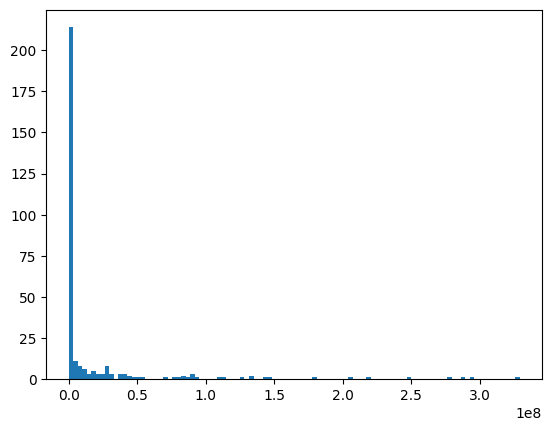

In [39]:
time_ns_raw = [msg[9] for msg in X_raw]
time_ns_raw
print("time_ns_raw:", time_ns_raw)
print("sum(time_ns_raw):", sum(time_ns_raw))

# # plot a scatter plot of the time_ns values
# plt.scatter(range(len(time_ns_raw)), time_ns_raw)

# plot a histogram of the time_ns values
plt.hist(time_ns_raw, bins=100)

time_ns_gen: [77685, 595474, 20774, 585180, 140635, 54666549, 4207143, 17534013, 1849101, 83697, 3550707, 20767160, 9897, 60239207, 150935, 933538, 22815215, 5327972, 8948683, 114851, 8538428, 35239395, 19358538, 28609, 8026002, 12039699, 111331, 54740, 46733, 4907289, 2416196, 26992283, 7361920, 85184840, 33596281, 517878, 79602221, 21548396, 59126122, 33571245, 229797, 37761451, 8237223, 140117167, 12657547, 329452, 130627308, 155940655, 91245829, 27586623, 142184465, 33663, 41301, 336084, 524426, 0, 24148, 56758, 164102, 98011, 5134078, 5756850, 35724278, 0, 0, 7169, 7562, 10354, 17544, 209, 257, 7845, 10768, 1791, 4188, 29714, 22049, 69804, 6242, 71734, 31540, 49648, 368847, 122247, 7144151, 437613, 1432294, 6620072, 36044278, 531061, 73771, 110371, 15197222, 3406676, 319064, 34197, 11957, 122591, 1687, 7402, 7950, 4890, 1813, 9106, 30649, 2924, 7109, 20696, 7581, 28871, 151460, 257, 1224, 2763, 1709, 12426, 43540, 197206, 9563, 413454, 1262939, 283304, 98097, 262, 197880, 57244, 5

(array([314.,  14.,   5.,  12.,   3.,   4.,   5.,   4.,   5.,   3.,   2.,
          6.,   3.,   3.,   4.,   3.,   2.,   1.,   0.,   2.,   1.,   1.,
          1.,   1.,   1.,   2.,   1.,   3.,   0.,   0.,   1.,   2.,   0.,
          1.,   1.,   2.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00000000e+00, 2.32877945e+06, 4.65755890e+06, 6.98633835e+06,
        9.31511780e+06, 1.16438972e+07, 1.39726767e+07, 1.63014562e+07,
        1.86302356e+07, 2.09590151e+07, 2.32877945e+07, 2.56165740e+07,
        2.79453534e+07, 3.02741329e+07, 3.26029123e+07, 3.49316918e+07,
        3.72604712e+07, 3.9589

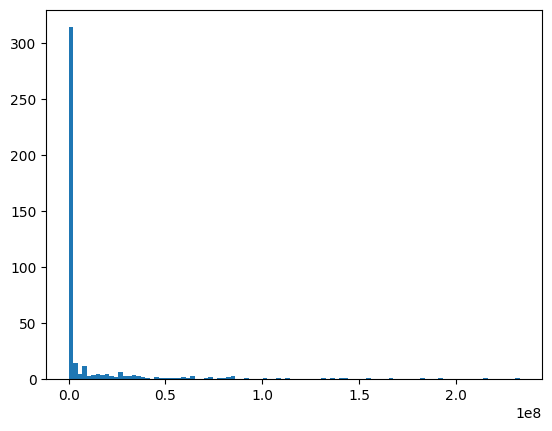

In [40]:
# extrat the ninth element of each message (time_ns)
time_ns_gen = [msg[9] for msg in decoded_x_gen]
time_ns_gen
print("time_ns_gen:", time_ns_gen)
print("sum(time_ns_gen):", sum(time_ns_gen))

sum(time_ns_raw) / sum(time_ns_gen)
print("off by a factor of:", sum(time_ns_raw) / sum(time_ns_gen))

# # plot a scatter plot of the time_ns values
# plt.scatter(range(len(time_ns_gen)), time_ns_gen)

# plot a histogram of the time_ns values
plt.hist(time_ns_gen, bins=100)

# time_s_gen = [msg[8] for msg in decoded_x_gen]
# time_s_gen
# sum(time_s_gen)

In [41]:
time

45196622443403

In [30]:
gen_start_time
time 

39709102275130

In [28]:
# # determine appropriate msg_seq_len for efficient block_size
# msg_seqL = 0
# # for i in range(1, 500):
# for i in range(1, 500):
#     msg_seqL = i
#     blk_size = msg_seqL*24 #- 1 # minus 1 for target rescaling
#     # if msg_seqL % 24 == 0:
#     if blk_size % 64 == 0 and blk_size % 24 == 0:
#         print(f"msg_seqL: {msg_seqL}, blk_size: {blk_size}")

# # msg_seqL: 112, blk_size: 2688

In [26]:
print("Number of sampling errors:", num_sampling_errors)
print("Number of symbol errors:", num_symbol_errors)
print("Number of time errors:", num_time_errors)
print("Number of price reference errors:", num_ref_errors)
print("Number of order placement errors:", num_errors)
total_errors = num_sampling_errors + num_symbol_errors + num_errors + num_time_errors + num_ref_errors
print("Total number of errors:", total_errors)
print("Error percentage:", round((total_errors / num_generation_steps) * 100, 2), "%")
# print("Error percentage:", round((total_errors / (num_generation_steps + 3000)) * 100, 2), "%")

Number of sampling errors: 0
Number of symbol errors: 0
Number of time errors: 0
Number of price reference errors: 0
Number of order placement errors: 18207
Total number of errors: 18207
Error percentage: 12.14 %


In [27]:
print("gen_start_time:", gen_start_time)
print("gen_end_time:", time)

sim_time_elapsed = time - gen_start_time
print("Simulation time elapsed (nanoseconds):", sim_time_elapsed)
print("Simulation time elapsed (seconds):", sim_time_elapsed / 1e9)
print("Simulation time elapsed (minutes):", sim_time_elapsed / 1e9 / 60)

gen_start_time: 43682039255737
gen_end_time: 45196622443403
Simulation time elapsed (nanoseconds): 1514583187666
Simulation time elapsed (seconds): 1514.583187666
Simulation time elapsed (minutes): 25.243053127766665


In [28]:
real_msg_per_sec = 70 # give or take, varies by time of day
sim_msg_per_sec = (num_generation_steps - total_errors) / (sim_time_elapsed / 1e9)
print("Real messages per second:", real_msg_per_sec)
print("Simulated messages per second:", sim_msg_per_sec)
# print("offset:", real_msg_per_sec / sim_msg_per_sec)

Real messages per second: 70
Simulated messages per second: 87.01601937302327


len(L1_gen): 131793


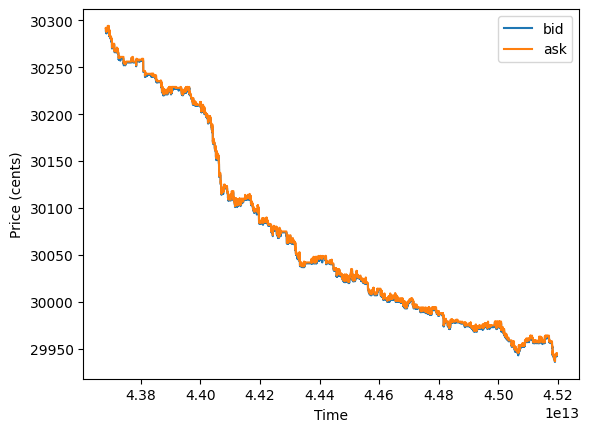

In [29]:
print("len(L1_gen):", len(L1_gen))

# plot L1_gen data
times = [L1_gen[i][0] for i in range(len(L1_gen))]
bids = [L1_gen[i][1][0] for i in range(len(L1_gen))]
asks = [L1_gen[i][2][0] for i in range(len(L1_gen))]
plt.plot(times, bids, label='bid')
plt.plot(times, asks, label='ask')

# # plot last 10000 time steps
# plt.plot(times[-10000:], bids[-10000:], label='bid')
# plt.plot(times[-10000:], asks[-10000:], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

len(last_prices_gen): 3910


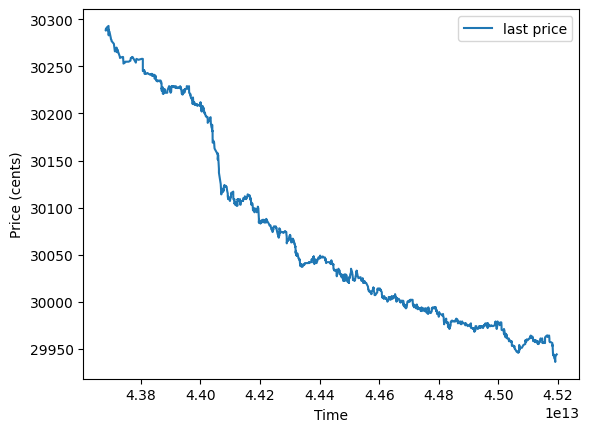

In [30]:
print("len(last_prices_gen):", len(last_prices_gen))

# plot last prices
times = [last_prices_gen[i][0] for i in range(len(last_prices_gen))]
prices = [last_prices_gen[i][1] for i in range(len(last_prices_gen))]
plt.plot(times, prices, label='last price')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

# TODO: put in *-minute buckets plot series

Total number of messages: 131793
Add Order percentage: 49.92 % (count: 65795 )
Execute Order percentage: 2.97 % (count: 3910 )
Modified Execute Order percentage: 0.0 % (count: 0 )
Cancel Order percentage: 40.57 % (count: 53474 )
Replace Order percentage: 6.54 % (count: 8614 )


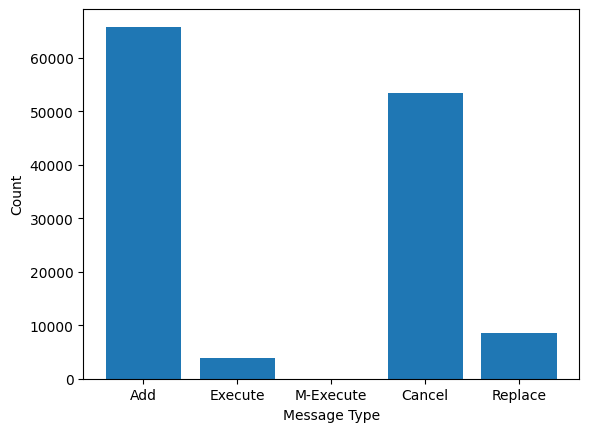

In [31]:
# print percentage of each message type
total_msgs = num_add_order_msgs + num_exec_order_msgs + num_execmod_order_msgs + num_full_cancel_order_msgs + num_partial_cancel_order_msgs + num_replace_order_msgs
print("Total number of messages:", total_msgs)
print("Add Order percentage:", round((num_add_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_add_order_msgs, ")")
print("Execute Order percentage:", round((num_exec_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_exec_order_msgs, ")")
print("Modified Execute Order percentage:", round((num_execmod_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_execmod_order_msgs, ")")
# print("Full Cancel Order percentage:", round((num_full_cancel_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_full_cancel_order_msgs, ")")
# print("Partial Cancel Order percentage:", round((num_partial_cancel_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_partial_cancel_order_msgs, ")")
print("Cancel Order percentage:", round(((num_full_cancel_order_msgs + num_partial_cancel_order_msgs) / total_msgs) * 100, 2), "%", "(count:", num_full_cancel_order_msgs + num_partial_cancel_order_msgs, ")")
print("Replace Order percentage:", round((num_replace_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_replace_order_msgs, ")")

# plot message type counts
# msg_types = ['Add', 'Execute', 'M-Execute', 'Full Cancel', 'Partial Cancel', 'Replace']
msg_types = ['Add', 'Execute', 'M-Execute', 'Cancel', 'Replace']
# msg_counts = [num_add_order_msgs, num_exec_order_msgs, num_execmod_order_msgs, num_full_cancel_order_msgs, num_partial_cancel_order_msgs, num_replace_order_msgs]
msg_counts = [num_add_order_msgs, num_exec_order_msgs, num_execmod_order_msgs, num_full_cancel_order_msgs + num_partial_cancel_order_msgs, num_replace_order_msgs]
plt.bar(msg_types, msg_counts)
# plt.rcParams['font.size'] = 8
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

# help?: https://stackoverflow.com/questions/26700598/matplotlib-showing-x-tick-labels-overlapping

In [32]:
# collect the order type of each order in order placement error list?
order_placement_error_types = [msg[2] for t, msg in order_placement_error_list]

# count the number of each order type in the order placement error list
print("Number of add order placement errors:", sum([1 for order_type in order_placement_error_types if order_type == 1]))
print("Number of exec order placement errors:", sum([1 for order_type in order_placement_error_types if order_type == 2]))
print("Number of execmod order placement errors:", sum([1 for order_type in order_placement_error_types if order_type == 3]))
print("Number of cancel order placement errors:", sum([1 for order_type in order_placement_error_types if order_type == 4]))
print("Number of replace order placement errors:", sum([1 for order_type in order_placement_error_types if order_type == 5]))

Number of add order placement errors: 0
Number of exec order placement errors: 0
Number of execmod order placement errors: 0
Number of cancel order placement errors: 11500
Number of replace order placement errors: 6707


In [33]:
matching_method

# how are orders being matched?
exact_match_count = matching_method['exact_match']
size_only_count = matching_method['size_only_match']
time_only_count = matching_method['time_only_match']
no_match_count = matching_method['no_match']
total_match_count = exact_match_count + size_only_count + time_only_count + no_match_count

print(f'Exact match: {exact_match_count} ({round((exact_match_count / total_match_count) * 100, 2)} %)')
print(f'Size only match: {size_only_count} ({round((size_only_count / total_match_count) * 100, 2)} %)')
print(f'Time only match: {time_only_count} ({round((time_only_count / total_match_count) * 100, 2)} %)')
print(f'No match: {no_match_count} ({round((no_match_count / total_match_count) * 100, 2)} %)')


Exact match: 4 (0.0 %)
Size only match: 162127 (90.93 %)
Time only match: 0 (0.0 %)
No match: 16167 (9.07 %)


In [34]:
wall_clock_elapsed = f"{(clock_end_time-clock_start_time)/60:.2f}"
print(f"Wall clock time elapsed: {wall_clock_elapsed} minutes")

Wall clock time elapsed: 349.85 minutes


In [36]:
metadata_filename = f'{parent_folder_path}/gen_data/{save_timestamp}/metadata_{date}_{sym}_{gen_start_time}_{t}_{save_timestamp}.txt'

#w tells python we are opening the file to write into it
outfile = open(metadata_filename, 'w')
outfile.write(f'Number of generation steps: {num_generation_steps}\n')
outfile.write(f'Checkpoint: {checkpoint}\n')
outfile.write(f'Use BPE: {use_bpe}\n')
outfile.write(f'msgs_to_load_LOB: {msgs_to_load_LOB}\n')
outfile.write(f'num_context_msgs: {num_context_msgs}\n')
outfile.write(f'Temperature: {temperature}\n')
outfile.write(f'Top-k: {top_k}\n')
outfile.write(f'Top-p: {top_p}\n')
outfile.write(f'Seed: {seed}\n')
outfile.write(f'Block size: {new_block_size}\n')
outfile.write(f'Number of sampling errors: {num_sampling_errors}\n')
outfile.write(f'Number of symbol errors: {num_symbol_errors}\n')
outfile.write(f'Number of time errors: {num_time_errors}\n')
outfile.write(f'Number of price reference errors: {num_ref_errors}\n')
outfile.write(f'Number of order placement errors: {num_errors}\n')
outfile.write(f'Total number of errors: {total_errors}\n')
outfile.write(f'Error percentage: {round((total_errors / num_generation_steps) * 100, 2)}%\n')
total_msgs = num_add_order_msgs + num_exec_order_msgs + num_execmod_order_msgs + num_full_cancel_order_msgs + num_partial_cancel_order_msgs + num_replace_order_msgs
outfile.write(f'Add order percentage: {round((num_add_order_msgs / total_msgs) * 100, 2)}% (count: {num_add_order_msgs}) \n')
outfile.write(f'Execute order percentage: {round((num_exec_order_msgs / total_msgs) * 100, 2)}% (count: {num_exec_order_msgs}) \n')
outfile.write(f'Execute modified order percentage: {round((num_execmod_order_msgs / total_msgs) * 100, 2)}% (count: {num_execmod_order_msgs}) \n')
outfile.write(f'Full cancel order percentage: {round((num_full_cancel_order_msgs / total_msgs) * 100, 2)}% (count: {num_full_cancel_order_msgs}) \n')
outfile.write(f'Partial cancel order percentage: {round((num_partial_cancel_order_msgs / total_msgs) * 100, 2)}% (count: {num_partial_cancel_order_msgs}) \n')
outfile.write(f'Replace order percentage: {round((num_replace_order_msgs / total_msgs) * 100, 2)}% (count: {num_replace_order_msgs}) \n')
outfile.write(f'Number of add order placement errors: {sum([1 for order_type in order_placement_error_types if order_type == 1])}\n')
outfile.write(f'Number of exec order placement errors: {sum([1 for order_type in order_placement_error_types if order_type == 2])}\n')
outfile.write(f'Number of execmod order placement errors: {sum([1 for order_type in order_placement_error_types if order_type == 3])}\n')
outfile.write(f'Number of cancel order placement errors: {sum([1 for order_type in order_placement_error_types if order_type == 4])}\n')
outfile.write(f'Number of replace order placement errors: {sum([1 for order_type in order_placement_error_types if order_type == 5])}\n')
outfile.write(f'Exact match: {exact_match_count} ({round((exact_match_count / total_match_count) * 100, 2)} %)\n')
outfile.write(f'Size only match: {size_only_count} ({round((size_only_count / total_match_count) * 100, 2)} %)\n')
outfile.write(f'Time only match: {time_only_count} ({round((time_only_count / total_match_count) * 100, 2)} %)\n')
outfile.write(f'No match: {no_match_count} ({round((no_match_count / total_match_count) * 100, 2)} %)\n')
outfile.write(f'gen_start_time: {gen_start_time}\n')
outfile.write(f'gen_end_time: {time}\n')
outfile.write(f'Simulation time elapsed (nanoseconds): {sim_time_elapsed}\n')
outfile.write(f'Simulation time elapsed (seconds): {sim_time_elapsed / 1e9}\n')
outfile.write(f'Simulation time elapsed (minutes): {sim_time_elapsed / 1e9 / 60}\n')
outfile.write(f'Simulated messages per second: {sim_msg_per_sec}\n')
wallclock_time_elapsed = f"{(clock_end_time-clock_start_time)/60:.2f}"
outfile.write(f'Wallclock time elapsed: {wallclock_time_elapsed}\n')

outfile.close() #Close the file when we’re done!

In [44]:
msg_per_sec = 10
est_comp_time_1 = round((1596503 // msg_per_sec) / 60 / 60, 2)
est_comp_time_2 = round((1956673 // msg_per_sec) / 60 / 60, 2)
est_comp_time_3 = round((1960770 // msg_per_sec) / 60 / 60, 2)
est_comp_time_4 = round((1214806 // msg_per_sec) / 60 / 60, 2)
est_comp_time_5 = round((1151383 // msg_per_sec) / 60 / 60, 2)
est_comp_time_6 = round((739800 // msg_per_sec) / 60 / 60, 2)
est_comp_time_7 = round((1395511 // msg_per_sec) / 60 / 60, 2)
est_comp_time_8 = round((1484259 // msg_per_sec) / 60 / 60, 2)
off_rate_1 = round(est_comp_time_1 / 6.5, 2)
off_rate_2 = round(est_comp_time_2 / 6.5, 2)
off_rate_3 = round(est_comp_time_3 / 6.5, 2)
off_rate_4 = round(est_comp_time_4 / 6.5, 2)
off_rate_5 = round(est_comp_time_5 / 6.5, 2)
off_rate_6 = round(est_comp_time_6 / 6.5, 2)
off_rate_7 = round(est_comp_time_7 / 6.5, 2)
off_rate_8 = round(est_comp_time_8 / 6.5, 2)

print(f"estimated completion time (hr): {est_comp_time_1}, off by factor of {off_rate_1}x")
print(f"estimated completion time (hr): {est_comp_time_2}, off by factor of {off_rate_2}x")
print(f"estimated completion time (hr): {est_comp_time_3}, off by factor of {off_rate_3}x")
print(f"estimated completion time (hr): {est_comp_time_4}, off by factor of {off_rate_4}x")
print(f"estimated completion time (hr): {est_comp_time_5}, off by factor of {off_rate_5}x")
print(f"estimated completion time (hr): {est_comp_time_6}, off by factor of {off_rate_6}x")
print(f"estimated completion time (hr): {est_comp_time_7}, off by factor of {off_rate_7}x")
print(f"estimated completion time (hr): {est_comp_time_8}, off by factor of {off_rate_8}x")

estimated completion time (hr): 44.35, off by factor of 6.82x
estimated completion time (hr): 54.35, off by factor of 8.36x
estimated completion time (hr): 54.47, off by factor of 8.38x
estimated completion time (hr): 33.74, off by factor of 5.19x
estimated completion time (hr): 31.98, off by factor of 4.92x
estimated completion time (hr): 20.55, off by factor of 3.16x
estimated completion time (hr): 38.76, off by factor of 5.96x
estimated completion time (hr): 41.23, off by factor of 6.34x


#### Generated data analytics

In [33]:
gen_data_df[-60:]

,ticker,order_id,event_type,direction,price_abs,price,fill_size,remain_size,delta_t_s,delta_t_ns,time_s,time_ns,old_id,price_ref,fill_size_ref,time_s_ref,time_ns_ref,old_price_abs
34537,40,19431,4,0,28696,-4,38,0,0,922,36377,996666614,-9999,-4,38,36377,479911267,-9999
34538,40,19476,2,1,28701,1,100,0,0,143760,36377,996810374,-9999,1,68,36367,726121632,-9999
34539,40,19477,1,0,28700,0,100,-9999,0,4459,36377,996814833,-9999,-9999,-9999,-9999,-9999,-9999
34540,40,18758,4,1,28701,1,100,0,0,48059,36377,996862892,-9999,1,100,36367,737191408,-9999
34541,40,8963,4,1,28707,7,100,0,0,75029,36377,996937921,-9999,8,100,36206,847495949,-9999
34542,40,19478,1,0,28697,-3,100,-9999,0,192750,36377,997130671,-9999,-9999,-9999,-9999,-9999,-9999
34543,40,19479,1,1,28701,1,100,-9999,0,142882,36377,997273553,-9999,-9999,-9999,-9999,-9999,-9999
34544,40,19457,4,0,28698,-2,100,0,0,19318,36377,997292871,-9999,-1,100,36377,995531954,-9999
34545,40,19472,4,0,28700,0,100,0,0,9098,36377,997301969,-9999,0,100,36377,996474064,-9999
34546,40,19480,1,1,28701,1,34,-9999,0,21830,36377,997323799,-9999,-9999,-9999,-9999,-9999,-9999


In [35]:
gen_data_df.iloc[-100:][:60]
np.min(gen_data_df['fill_size'])
sorted_fill_sizes = np.sort(gen_data_df['fill_size'])
print("10 smallest fill sizes:", sorted_fill_sizes[:10])

sorted_index_fill_sizes = np.argsort(gen_data_df['fill_size'])
min_idx_fillsize = sorted_index_fill_sizes[0]
gen_data_df.iloc[(min_idx_fillsize - 5): (min_idx_fillsize + 5)]

for i in range(len(gen_data_df)):
    if gen_data_df['fill_size'][i] == 0:
        print("index:", i)
        # print("message:", gen_data_df.iloc[(i - 5): (i + 5)])
# zero_idx = 13406
# gen_data_df.iloc[(zero_idx - 5):(zero_idx + 5)]

# gen_data_df.iloc[-100:][:60]

10 smallest fill sizes: [1 1 1 1 1 1 1 1 1 1]


In [46]:
# count how many times a msg has price == 0
zero_price_count = 0
for i in range(len(gen_data_df)):
    if gen_data_df['price'][i] == 0:
        zero_price_count += 1
print("Number of messages with price == 0:", zero_price_count, "(", round((zero_price_count / len(gen_data_df)) * 100, 2), "% )")

Number of messages with price == 0: 2985 ( 8.63 % )


In [67]:
sorted_delta_ts = np.sort(gen_data_df['delta_t_s'])
print("10 largest delta_ts:", sorted_delta_ts[-10:])

sorted_prices = np.sort(gen_data_df['price'])
print("10 smallest price:", sorted_prices[:1000])

10 largest delta_ts: [  0   0   0   0   0   0   0   0   0 785]
10 smallest price: [-999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 

In [32]:
######## NEW
# broke at 26006
# some data in training loop may improperly be NaN bc they refer order before market open time... could this be leading to issues here?
# is this happening because not enough execution orders are coming through? (i.e. not enough liquidity leaving the order book)
# is this happening because of sudden jumps in values of order ids? (i.e. starting new generated order id sequence at zero messes up predictive abilities)
gen_data_df[-60:] # last message price_ref is NaN.... why does generation degrade here? review all code in order matching/sim loop

,ticker,order_id,event_type,direction,price_abs,price,fill_size,remain_size,delta_t_s,delta_t_ns,time_s,time_ns,old_id,price_ref,fill_size_ref,time_s_ref,time_ns_ref,old_price_abs
24290,40,13693,1,1,28691,3,100,-9999,0,76602,36415,881689971,-9999,-9999,-9999,-9999,-9999,-9999
24291,40,13694,1,0,28684,-4,100,-9999,0,927,36415,881690898,-9999,-9999,-9999,-9999,-9999,-9999
24292,40,13695,1,1,28690,2,100,-9999,0,1155,36415,881692053,-9999,-9999,-9999,-9999,-9999,-9999
24293,40,13696,1,1,28690,2,100,-9999,0,22030,36415,881714083,-9999,-9999,-9999,-9999,-9999,-9999
24294,40,12348,4,1,28694,6,6,0,0,18956,36415,881733039,-9999,6,6,36376,553144698,-9999
24295,40,13298,4,0,28671,-17,100,0,0,19860,36415,881752899,-9999,-14,100,36405,699374235,-9999
24296,40,13697,1,1,28693,5,100,-9999,0,185310,36415,881938209,-9999,-9999,-9999,-9999,-9999,-9999
24297,40,13698,1,1,28691,3,12,-9999,0,230159,36415,882168368,-9999,-9999,-9999,-9999,-9999,-9999
24298,40,13698,4,1,28691,3,12,0,0,13350,36415,882181718,-9999,3,12,36415,882168368,-9999
24299,40,13699,1,1,28690,2,100,-9999,0,1024403,36415,883206121,-9999,-9999,-9999,-9999,-9999,-9999


In [37]:
# broke at 26001, final message was 26088
gen_data_df[-60:]

,ticker,order_id,event_type,direction,price_abs,price,fill_size,remain_size,delta_t_s,delta_t_ns,time_s,time_ns,old_id,price_ref,fill_size_ref,time_s_ref,time_ns_ref,old_price_abs
24295,40,13298,4,0,28671,-17,100,0,0,19860,36415,881752899,-9999,-14,100,36405,699374235,-9999
24296,40,13697,1,1,28693,5,100,-9999,0,185310,36415,881938209,-9999,-9999,-9999,-9999,-9999,-9999
24297,40,13698,1,1,28691,3,12,-9999,0,230159,36415,882168368,-9999,-9999,-9999,-9999,-9999,-9999
24298,40,13698,4,1,28691,3,12,0,0,13350,36415,882181718,-9999,3,12,36415,882168368,-9999
24299,40,13699,1,1,28690,2,100,-9999,0,1024403,36415,883206121,-9999,-9999,-9999,-9999,-9999,-9999
24300,40,11881,4,0,28686,-2,100,0,0,2107136,36415,885313257,-9999,-1,100,36361,837144957,-9999
24301,40,13700,1,1,28690,2,100,-9999,0,4053108,36415,889366365,-9999,-9999,-9999,-9999,-9999,-9999
24302,40,13701,1,0,28687,-1,99,-9999,0,6137334,36415,895503699,-9999,-9999,-9999,-9999,-9999,-9999
24303,40,13326,4,1,28690,2,100,0,0,17309694,36415,912813393,-9999,2,100,36408,134676343,-9999
24304,40,13702,1,1,28690,2,100,-9999,0,107007,36415,912920400,-9999,-9999,-9999,-9999,-9999,-9999


In [63]:
36415943069709 + 785*1000000000 + 54341023

37200997410732

In [39]:
# print new order book state
# print("L3 bid data:", order_books['AAPL'].get_l3_bid_data())
# print("L3 ask data:", order_books['AAPL'].get_l3_ask_data())

In [47]:
real_msg_df = pd.DataFrame(np.array(np.load(proc_data_dir, mmap_mode='r')), columns=[
              "ticker", "order_id", "event_type", "direction", "price_abs", "price",
              "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
              "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])

# filter df to only include messages from 'time_s' >= 34200 and 'time_s' <= 57600
real_msg_df = real_msg_df[(real_msg_df['time_s'] >= 34200) & (real_msg_df['time_s'] <= 57600)] 
real_msg_df

,ticker,order_id,event_type,direction,price_abs,price,fill_size,remain_size,delta_t_s,delta_t_ns,time_s,time_ns,old_id,price_ref,fill_size_ref,time_s_ref,time_ns_ref,old_price_abs
7090,40,3917089,4,0,28380,-583,1300,100,0,13315515,34200,7441066,-9999,-560,1400,29299,276144472,-9999
7091,40,7872401,1,0,27499,-999,100,-9999,0,15161946,34200,22603012,-9999,-9999,-9999,-9999,-9999,-9999
7092,40,7872405,1,0,28368,-595,100,-9999,0,6899,34200,22609911,-9999,-9999,-9999,-9999,-9999,-9999
7093,40,7872421,1,1,30400,999,100,-9999,0,16782,34200,22626693,-9999,-9999,-9999,-9999,-9999,-9999
7094,40,7872457,1,1,29532,569,100,-9999,0,10618,34200,22637311,-9999,-9999,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485386,40,232234585,4,1,29230,64,2,0,0,17164,57600,997315632,-9999,15,2,56462,166500010,-9999
1485387,40,249470025,4,1,29230,64,10,0,0,241,57600,997315873,-9999,86,10,57480,410122588,-9999
1485388,40,253681353,4,1,29230,64,2700,0,0,222,57600,997316095,-9999,72,2700,57593,580365408,-9999
1485389,40,253681357,4,1,29230,64,2700,0,0,2337,57600,997318432,-9999,72,2700,57593,580375079,-9999


In [39]:
sorted_delta_ts_real = np.sort(real_msg_df['delta_t_s'])
print("10 largest delta_ts:", sorted_delta_ts_real[-10:])

sorted_fill_sizes_real = np.sort(real_msg_df['fill_size'])
print("10 smallest fill sizes:", sorted_fill_sizes_real[:10])

real_msg_df[287600:][:60]

10 largest delta_ts: [1 1 1 1 2 2 2 2 2 2]
10 smallest fill sizes: [1 1 1 1 1 1 1 1 1 1]


,ticker,order_id,event_type,direction,price_abs,price,fill_size,remain_size,delta_t_s,delta_t_ns,time_s,time_ns,old_id,price_ref,fill_size_ref,time_s_ref,time_ns_ref,old_price_abs
294690,40,42347465,1,0,28686,-1,50,-9999,0,230,36144,378694059,-9999,-9999,-9999,-9999,-9999,-9999
294691,40,42347493,1,0,28686,-1,100,-9999,0,47090,36144,378741149,-9999,-9999,-9999,-9999,-9999,-9999
294692,40,42251849,4,1,28689,2,100,0,0,6503,36144,378747652,-9999,7,100,36137,474909417,-9999
294693,40,42347513,1,1,28694,7,100,-9999,0,79207,36144,378826859,-9999,-9999,-9999,-9999,-9999,-9999
294694,40,42347541,1,0,28677,-10,31,-9999,0,238298,36144,379065157,-9999,-9999,-9999,-9999,-9999,-9999
294695,40,42003305,4,1,28689,2,100,0,0,13552,36144,379078709,-9999,21,100,36121,542933006,-9999
294696,40,42025741,4,1,28961,273,100,0,0,30998,36144,379109707,-9999,287,100,36122,727464831,-9999
294697,40,42347557,1,1,28976,288,100,-9999,0,4760,36144,379114467,-9999,-9999,-9999,-9999,-9999,-9999
294698,40,42006097,4,0,28658,-30,31,0,0,56047,36144,379170514,-9999,-11,31,36121,633698979,-9999
294699,40,41940157,4,0,28627,-61,48,0,0,202937,36144,379373451,-9999,-29,48,36118,9717322,-9999


Total number of messages: 34597
Add Order percentage: 46.29 % (count: 16015 )
Execute Order percentage: 3.19 % (count: 1105 )
Modified Execute Order percentage: 0.01 % (count: 2 )
Full Cancel Order percentage: 44.01 % (count: 15225 )
Replace Order percentage: 6.5 % (count: 2250 )


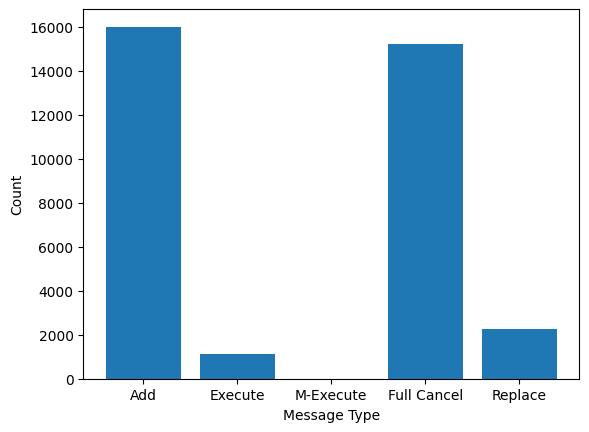

In [48]:
# num_add_order_msgs_real = real_msg_df[real_msg_df['event_type'] == 1].shape[0]
# num_exec_order_msgs_real = real_msg_df[real_msg_df['event_type'] == 2].shape[0]
# num_execmod_order_msgs_real = real_msg_df[real_msg_df['event_type'] == 3].shape[0]
# num_full_cancel_order_msgs_real = real_msg_df[real_msg_df['event_type'] == 4].shape[0]
# # num_partial_cancel_order_msgs_real = real_msg_df[real_msg_df['event_type'] == 4].shape[0]
# num_replace_order_msgs_real = real_msg_df[real_msg_df['event_type'] == 5].shape[0]
size_gen_seq = len(gen_data_df)
real_msg_df_seq = real_msg_df[287600:][:size_gen_seq]
num_add_order_msgs_real = real_msg_df_seq[real_msg_df_seq['event_type'] == 1].shape[0]
num_exec_order_msgs_real = real_msg_df_seq[real_msg_df_seq['event_type'] == 2].shape[0]
num_execmod_order_msgs_real = real_msg_df_seq[real_msg_df_seq['event_type'] == 3].shape[0]
num_full_cancel_order_msgs_real = real_msg_df_seq[real_msg_df_seq['event_type'] == 4].shape[0]
# num_partial_cancel_order_msgs_real = real_msg_df_seq[real_msg_df_seq['event_type'] == 4].shape[0]
num_replace_order_msgs_real = real_msg_df_seq[real_msg_df_seq['event_type'] == 5].shape[0]
total_msgs_real = num_add_order_msgs_real + num_exec_order_msgs_real + num_execmod_order_msgs_real + num_full_cancel_order_msgs_real + num_replace_order_msgs_real
print("Total number of messages:", total_msgs_real)
print("Add Order percentage:", round((num_add_order_msgs_real / total_msgs_real) * 100, 2), "%", "(count:", num_add_order_msgs_real, ")")
print("Execute Order percentage:", round((num_exec_order_msgs_real / total_msgs_real) * 100, 2), "%", "(count:", num_exec_order_msgs_real, ")")
print("Modified Execute Order percentage:", round((num_execmod_order_msgs_real / total_msgs_real) * 100, 2), "%", "(count:", num_execmod_order_msgs_real, ")")
print("Full Cancel Order percentage:", round((num_full_cancel_order_msgs_real / total_msgs_real) * 100, 2), "%", "(count:", num_full_cancel_order_msgs_real, ")")
# print("Partial Cancel Order percentage:", round((num_partial_cancel_order_msgs_real / total_msgs_real) * 100, 2), "%", "(count:", num_partial_cancel_order_msgs_real, ")")
print("Replace Order percentage:", round((num_replace_order_msgs_real / total_msgs_real) * 100, 2), "%", "(count:", num_replace_order_msgs_real, ")")

# plot message type counts
msg_types = ['Add', 'Execute', 'M-Execute', 'Full Cancel', 'Replace']
msg_counts = [num_add_order_msgs_real, num_exec_order_msgs_real, num_execmod_order_msgs_real, num_full_cancel_order_msgs_real, num_replace_order_msgs_real]
plt.bar(msg_types, msg_counts)
# plt.rcParams['font.size'] = 8
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

In [53]:
# count how many times a msg in 'real_msg_df_seq' has price == 0 
# zero_price_count_real = 0
# for i in range(len(real_msg_df_seq)):
#     if real_msg_df_seq['price'][i] == 0:
#         zero_price_count_real += 1
# print("Number of messages with price == 0:", zero_price_count_real, "(", round((zero_price_count_real / len(real_msg_df_seq)) * 100, 2), "% )")

# see how many messages in 'real_msg_df_seq' have price == 0
zero_price_count_real = real_msg_df_seq[real_msg_df_seq['price'] == 0].shape[0]
percent_zero_price_real = round((zero_price_count_real / len(real_msg_df_seq)) * 100, 2)
print("Number of messages with price == 0:", zero_price_count_real, "(", percent_zero_price_real, "% )")

Number of messages with price == 0: 1007 ( 2.91 % )


max fill size: 3900
min fill size: 0
max fill size (plot_n): 600
min fill size (plot_n): 1


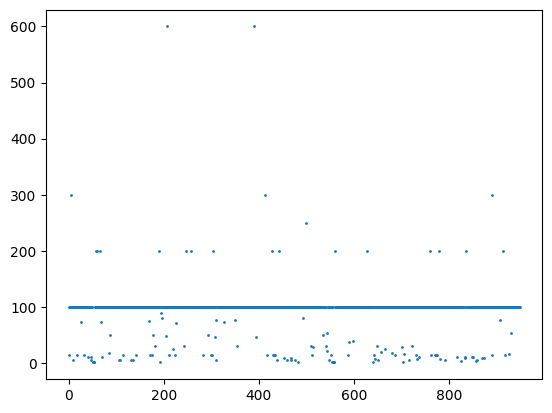

In [42]:
plot_n = 950
print("max fill size:", np.max(gen_data_df['fill_size']))
print("min fill size:", np.min(gen_data_df['fill_size']))
print("max fill size (plot_n):", np.max(gen_data_df['fill_size'][:plot_n]))
print("min fill size (plot_n):", np.min(gen_data_df['fill_size'][:plot_n]))

# plot a scatter plot of order fill sizes
plt.scatter(range(len(gen_data_df['fill_size'][:plot_n])), gen_data_df['fill_size'][:plot_n], s=1)

len(L1_gen): 27836


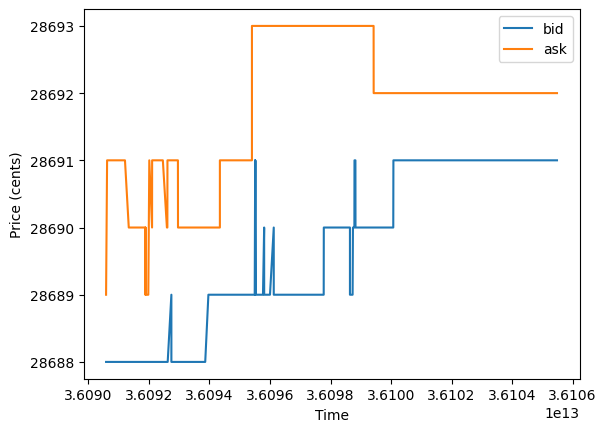

In [43]:
print("len(L1_gen):", len(L1_gen))

# plot L1_gen data
times = [L1_gen[i][0] for i in range(len(L1_gen))]
bids = [L1_gen[i][1][0] for i in range(len(L1_gen))]
asks = [L1_gen[i][2][0] for i in range(len(L1_gen))]
# plt.plot(times, bids, label='bid')
# plt.plot(times, asks, label='ask')

# # plot last 10000 time steps
# plt.plot(times[-10000:], bids[-10000:], label='bid')
# plt.plot(times[-10000:], asks[-10000:], label='ask')

# plot first 10000 time steps
# plot_n = 950
plt.plot(times[:plot_n], bids[:plot_n], label='bid')
plt.plot(times[:plot_n], asks[:plot_n], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

In [44]:
# L1_gen[:plot_n] #[-100:]

max delta_t_ns size: 232420687
min delta_t_ns size: 0


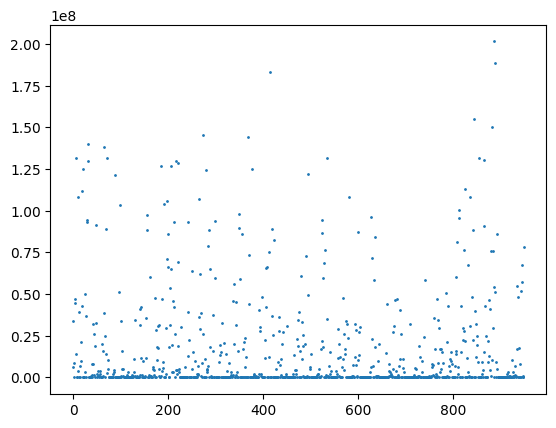

In [45]:
gen_data_df['delta_t_ns'] #[:plot_n]

print("max delta_t_ns size:", np.max(gen_data_df['delta_t_ns']))
print("min delta_t_ns size:", np.min(gen_data_df['delta_t_ns']))

# plot a scatter plot of delta_t_ns values
plt.scatter(range(len(gen_data_df['delta_t_ns'][:plot_n])), gen_data_df['delta_t_ns'][:plot_n], s=1)

max price dev size: 999
min price dev size: -999


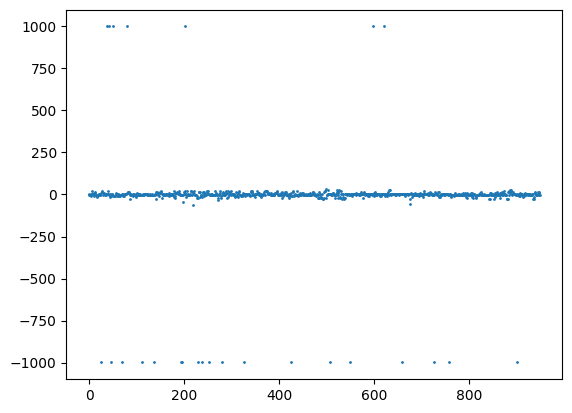

In [46]:
gen_data_df['price'] #[:plot_n]

print("max price dev size:", np.max(gen_data_df['price']))
print("min price dev size:", np.min(gen_data_df['price']))

# plot a scatter plot of price values
plt.scatter(range(len(gen_data_df['price'][:plot_n])), gen_data_df['price'][:plot_n], s=1)

In [47]:
# gen_data_df[:plot_n][-50:]

#### Scratch paper

In [57]:
from equities.fast_model import apply_rotary_emb, repeat_kv, reshape_for_broadcast
import math

n_rep = model.params.n_heads // model.params.n_kv_heads

In [53]:
def apply_rotary_emb_single(
    x: torch.Tensor,
    freqs_cos: torch.Tensor,
    freqs_sin: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:

    # reshape x to match the complex representation
    x_r, x_i = x.float().reshape(x.shape[:-1] + (-1, 2)).unbind(-1)

    # reshape freqs_cos and freqs_sin for broadcasting
    freqs_cos = reshape_for_broadcast(freqs_cos, x_r)
    freqs_sin = reshape_for_broadcast(freqs_sin, x_r)

    # apply rotation using real numbers
    x_out_r = x_r * freqs_cos - x_i * freqs_sin
    x_out_i = x_r * freqs_sin + x_i * freqs_cos

    # flatten last two dimensions
    x_out = torch.stack([x_out_r, x_out_i], dim=-1).flatten(3)

    return x_out.type_as(x)

In [55]:
###### get xq tensor for next notebook cell stuff
x_i = x[:,-1].reshape(-1,1) # last token in sequence
print("x_i.shape:", x_i.shape)
print("x_i:", x_i)

input_pos = x.shape[1] - 1
print("input_pos:", input_pos)
_bsz, seqlen = x_i.shape # 1, 1

h = model.tok_embeddings(x_i)
print("h.shape:", h.shape)

freqs_cos = model.freqs_cos[input_pos:input_pos+seqlen]
freqs_sin = model.freqs_sin[input_pos:input_pos+seqlen]
print("freqs_cos.shape:", freqs_cos.shape)
print("freqs_sin.shape:", freqs_sin.shape)

x_input = model.layers[0].attention_norm(h)
print("x_input.shape:", x_input.shape)

xq = model.layers[0].attention.wq(x_input)
print("xq.shape:", xq.shape)

head_dim = model.params.dim // model.params.n_heads
xq = xq.view(_bsz, seqlen, model.params.n_heads, head_dim)
print("xq.shape:", xq.shape)

# xk_test = model.layers[0].attention.wk(x_input)
# xk_test = xk_test.view(_bsz, seqlen, model.params.n_kv_heads, head_dim)
# print("xk_test.shape:", xk_test.shape)
# assert xk_test.shape == xq.shape # passes test

xq = apply_rotary_emb_single(xq, freqs_cos, freqs_sin)
print("xq.shape:", xq.shape) # size unchanged

x_i.shape: torch.Size([1, 1])
x_i: tensor([[648]], device='cuda:0')
input_pos: 10319
h.shape: torch.Size([1, 1, 768])
freqs_cos.shape: torch.Size([1, 32])
freqs_sin.shape: torch.Size([1, 32])
x_input.shape: torch.Size([1, 1, 768])
xq.shape: torch.Size([1, 1, 768])
xq.shape: torch.Size([1, 1, 12, 64])
xq.shape: torch.Size([1, 1, 12, 64])


In [56]:
# msg_debug
print(model.kv_cache[0].key.shape)
print(model.kv_cache[0].value.shape)

xk = model.kv_cache[0].key
xv = model.kv_cache[0].value

bsz = 1
# start_pos = 10342
start_pos = input_pos
T = 1
xk = xk[:bsz, : start_pos + T]
xv = xv[:bsz, : start_pos + T]
print(xk.shape)
print(xv.shape)

xk = repeat_kv(xk, n_rep)
xv = repeat_kv(xv, n_rep)
print(xk.shape)
print(xv.shape)

# make heads into a batch dimension
xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
xk = xk.transpose(1, 2)
xv = xv.transpose(1, 2)
print("batch xq.shape:", xq.shape)
print("batch xk.shape:", xk.shape)
print("batch xv.shape:", xv.shape)

torch.Size([1, 10367, 12, 64])
torch.Size([1, 10367, 12, 64])
torch.Size([1, 10320, 12, 64])
torch.Size([1, 10320, 12, 64])
torch.Size([1, 10320, 12, 64])
torch.Size([1, 10320, 12, 64])
batch xq.shape: torch.Size([1, 12, 1, 64])
batch xk.shape: torch.Size([1, 12, 10320, 64])
batch xv.shape: torch.Size([1, 12, 10320, 64])


In [29]:
mask = torch.full((1, 1, model.params.max_seq_len, model.params.max_seq_len), float("-inf"), device=device)
mask = torch.triu(mask, diagonal=1)
print("mask.shape:", mask.shape)
mask

mask.shape: torch.Size([1, 1, 10368, 10368])


tensor([[[[0., -inf, -inf,  ..., -inf, -inf, -inf],
          [0., 0., -inf,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [0., 0., 0.,  ..., 0., -inf, -inf],
          [0., 0., 0.,  ..., 0., 0., -inf],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [43]:
# sliding window attention (swa) mask
# window_size = 5184 # 10368 / 2 = 5184, same formula used by mistral 7b for calculating window size (context_len / 2)
window_size = 5
# swa_mask = torch.full((1, 1, model.params.max_seq_len, model.params.max_seq_len), float("-inf"), device=device)
swa_mask = torch.full((1, 1, 20, 20), float("-inf"), device=device)
swa_mask = torch.triu(swa_mask, diagonal=1)
swa_mask = torch.triu(swa_mask, diagonal=-window_size)
# not correct, follow method used here?: https://github.com/lucidrains/local-attention/blob/master/local_attention/local_attention.py
print("swa_mask.shape:", swa_mask.shape)
swa_mask

swa_mask.shape: torch.Size([1, 1, 20, 20])


tensor([[[[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0

In [36]:
8192 // 32
# 8192 / 4096
# 10368 // 32
10368 / 2 
# 5184 // 32

162

In [64]:
# self-attention
with torch.no_grad():
    scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(head_dim)
    # assert hasattr(self, 'mask')
    scores = scores + mask[:, :, :seqlen, :seqlen]   # (bs, n_local_heads, seqlen, cache_len + seqlen)
print("scores.shape:", scores.shape)
scores
# scores = torch.nn.functional.softmax(scores.float(), dim=-1).type_as(xq)
# output = torch.matmul(scores, xv)  # (bs, n_local_heads, seqlen, head_dim)

scores.shape: torch.Size([1, 12, 1, 10320])


tensor([[[[-2.6003e-01,  3.8623e-01,  3.3498e-01,  ..., -2.3681e-01,
            6.6732e-01, -2.1959e-01]],

         [[-3.8998e+00, -5.8728e-01,  2.5227e-01,  ...,  3.9170e-01,
            3.4713e-01, -4.4018e-01]],

         [[-1.5059e-01, -1.2565e-01,  1.3263e+00,  ..., -9.3774e-02,
            4.8610e-01, -1.5962e-01]],

         ...,

         [[-7.2178e-01,  2.9351e-03, -1.5578e+00,  ..., -3.4302e-02,
           -2.4721e-02,  1.3784e-02]],

         [[ 7.6198e-01, -1.1262e+00, -3.2533e+00,  ...,  1.9666e+00,
           -9.6419e-01,  9.7348e-01]],

         [[ 1.0758e+00,  2.6840e+00,  6.1702e-01,  ...,  8.0292e-01,
           -4.1793e-01,  2.8338e-01]]]], device='cuda:0')

In [24]:
past_key = model.kv_cache[0].key
past_value = model.kv_cache[0].value
print(past_key.shape)

# sliding window kv cache
slicing_tokens = 1
sw_key = (past_key[:, slicing_tokens:, :, :])
print(sw_key.shape)

torch.Size([1, 10343, 12, 64])
torch.Size([1, 10342, 12, 64])


In [25]:
# streaming_llm kv cache
sink_tokens = 0 # 24

sink_side = past_key[:, 0:sink_tokens, :, :]
print(sink_side.shape)
# recent_side = past_key[:, sink_tokens:, :, :] # remove an additional 24 tokens for new message?
# in theory, would be better to remove one token as a time, since we would be able to use more context at a time
recent_side = past_key[:, (sink_tokens + encoded_tok_len):, :, :]
print(recent_side.shape)

stream_key = torch.cat((sink_side, recent_side), dim=1)
print(stream_key.shape)

torch.Size([1, 0, 12, 64])
torch.Size([1, 10319, 12, 64])
torch.Size([1, 10319, 12, 64])


In [87]:
# apply position transromation to keys
cache_size = stream_key.shape[1]
print(cache_size)
# freqs_cos_cache = model.freqs_cos[:cache_size]
# freqs_sin_cache = model.freqs_sin[:cache_size]
# print(freqs_cos_cache.shape)
# print(freqs_sin_cache.shape)
freq_cache = (model.freqs_cos[:cache_size], model.freqs_sin[:cache_size])
freqs_cos_cache, freqs_sin_cache = freq_cache
print(freqs_cos_cache.shape)
print(freqs_sin_cache.shape)

stream_key = apply_rotary_emb_single(stream_key, freqs_cos_cache, freqs_sin_cache)
print(stream_key.shape)

10367
torch.Size([10367, 32])
torch.Size([10367, 32])
torch.Size([1, 10367, 12, 64])


In [20]:
test_freq = torch.arange(24)
print(test_freq.shape)
print(test_freq)

fr1 = test_freq[14:14+1]
print(fr1.shape)
print(fr1)

fr2 = test_freq[:14+1]
print(fr2.shape)
print(fr2)

test_freq[0:24]
test_freq[10:].roll(-5)

torch.Size([24])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23])
torch.Size([1])
tensor([14])
torch.Size([15])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 10, 11, 12, 13, 14])

In [27]:
nasdaq_agent.messages[-1]

(1,
 OrderCancelledMsg(message_id=19059, order=(Agent 1 @ 1970-01-01 09:30:25) : BID 100 AAPL @ $188.80))

In [35]:
vars(nasdaq_agent.messages[-2][1].order) #.time_placed #.order_id

{'agent_id': 1,
 'time_placed': 34224470830282,
 'symbol': 'AAPL',
 'quantity': 100,
 'side': <Side.BID: 'BID'>,
 'order_id': 54,
 'fill_price': 18880,
 'tag': None,
 'limit_price': 18880,
 'is_hidden': False,
 'is_price_to_comply': False,
 'insert_by_id': False,
 'is_post_only': False}

In [21]:
vocab.ENCODING #['type'] #[1][3:]

{'time': (array([-10000, -20000,  -9999, ...,    997,    998,    999], dtype=int32),
  array([   0,    1,    2, ..., 1000, 1001, 1002], dtype=int32)),
 'type': (array([-10000, -20000,  -9999,      1,      2,      3,      4,      5],
        dtype=int32),
  array([   0,    1,    2, 1003, 1004, 1005, 1006, 1007], dtype=int32)),
 'size': (array([-10000, -20000,  -9999, ...,   9997,   9998,   9999], dtype=int32),
  array([    0,     1,     2, ..., 11005, 11006, 11007], dtype=int32)),
 'price': (array([-10000, -20000,  -9999, ...,    997,    998,    999], dtype=int32),
  array([    0,     1,     2, ..., 12005, 12006, 12007], dtype=int32)),
 'sign': (array([-10000, -20000,  -9999,     -1,      1], dtype=int32),
  array([    0,     1,     2, 12008, 12009], dtype=int32)),
 'side': (array([-10000, -20000,  -9999,      0,      1], dtype=int32),
  array([    0,     1,     2, 12010, 12011], dtype=int32)),
 'ticker': (array([-10000, -20000,  -9999,      1,      2,      3,      4,      5,
          

In [ ]:
# FIELD_ENC_TYPES = {
#     'ticker': 'ticker', 0
#     'type': 'type', 1
#     'side': 'side', 2
#     'price': 'price', 3-4
#     'fill_size': 'size', 5
#     'remain_size': 'size', 6
#     'delta_t_s': 'time', 7
#     'delta_t_ns': 'time', 8-10
#     'time_s': 'time', 11-12
#     'time_ns': 'time', 13-15
#     'price_ref': 'price', 16-17
#     'fill_size_ref': 'size', 18
#     'time_s_ref': 'time', 19-20
#     'time_ns_ref': 'time', 21-23
# }
# TOK_LENS = np.array((1, 1, 1, 2, 1, 1, 1, 3, 2, 3, 2, 1, 2, 3))

In [18]:
def relevant_mask(tok_pos, logits, vocab_encoding, device):
    # determine field and special tokens to include
    include_nan = False
    if tok_pos == 0:
        field = 'ticker'
    elif tok_pos == 1:
        field = 'type'
    elif tok_pos == 2:
        field = 'side'
    elif tok_pos in [3, 16]:
        field = 'sign'
        include_nan = True
    elif tok_pos in [4, 17]:
        field = 'price'
        include_nan = True
    elif tok_pos in [5, 6, 18]:
        field = 'size'
        include_nan = True
    elif tok_pos in [7, 8, 9, 10, 11, 12, 13, 14, 15]:
        field = 'time'
    elif tok_pos in [19, 20, 21, 22, 23]:
        field = 'time'
        include_nan = True

    # select relevant tokens, excluding special tokens
    if not include_nan:
        relevant_indices = vocab_encoding[field][1][3:]
    else:
        relevant_indices = vocab_encoding[field][1][2:]
    # prepare tensors for scattering
    relevant_destination = torch.zeros(1, logits.shape[1], device=device)
    relevant_indices = torch.tensor(relevant_indices, dtype=torch.int64, device=device).unsqueeze(0)
    relevant_src = torch.ones(1, relevant_indices.shape[1], device=device)
    # place the values in relevant_src at the indices in relevant_indices in relevant_destination
    relevant_mask = relevant_destination.scatter(1, index=relevant_indices, src=relevant_src).bool()
    # mask the indices in logits that are not relevant for the current field
    logits.masked_fill_(~relevant_mask, float("-inf"))

    return logits

In [19]:
# top_k = None
print("x.shape:", x.shape)
print("x:", x)
print("temperature:", temperature)
print("top_k:", top_k)
print("top_p:", top_p)

from torch.nn import functional as F

idx = x
B,T = idx.shape
input_pos = idx.shape[1] - 1
KVCACHE = True
start = True # False
roll = False
new_block_size = 2688
vocab_encoding = vocab.ENCODING
use_relevant_mask = True

# top_p = 0.9
raw_logits = []
relevant_logits = []

for tok_pos in range(encoded_tok_len):
    print(f"tok_pos: {tok_pos}")
    # if the sequence context is growing too long we must crop it at block_size
    idx_cond = idx # if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
    # forward the model to get the logits for the index in the sequence
    if KVCACHE and not start:
        x_idx = idx_cond[:,-1].reshape(-1,1)
    else:
        x_idx = idx_cond
        input_pos = 0
    # print("input_pos:", input_pos)
    # print("x_idx.shape:", x_idx.shape)
    logits = model.forward(x_idx, None, kv_cache=KVCACHE, max_seq_length=new_block_size, input_pos=input_pos, roll=roll)
    # print("logits.shape:", logits.shape)
    logits = logits[:, -1, :] # crop to just the final time step
    # print("logits.shape:", logits.shape)
    # print("logits:", logits)

    if temperature == 0.0: # greedy sampling:
        # "sample" the single most likely index
        _, idx_next = torch.topk(logits, k=1, dim=-1)
    else:
        # pluck the logits at the final step and scale by desired temperature
        logits = logits / temperature
        raw_logits.append(logits.clone().detach()) #### for plotting
        # optionally mask indices that are not relevant for the current token field
        if use_relevant_mask:
            logits = relevant_mask(tok_pos, logits, vocab_encoding, logits.device)
            relevant_logits.append(logits.clone().detach()) #### for plotting
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        if top_p > 0.0:
            # First sort and calculate cumulative sum of probabilities.
            sorted_logits, sorted_indices = torch.sort(logits, descending=False)
            cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
            # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
            sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
            # scatter sorted tensors to original indexing
            indices_to_remove = sorted_indices_to_remove.scatter(
                1, sorted_indices, sorted_indices_to_remove
            )
            logits.masked_fill_(indices_to_remove, float("-inf")) # masks all positions in indices_to_remove that are True
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
    # print("idx_next.shape:", idx_next.shape)
    print("idx_next:", idx_next)
    input_pos = idx.shape[1]
    start = False
    roll = False
    # append sampled index to the running sequence and continue
    idx = torch.cat((idx, idx_next), dim=1)

print("msg:", idx[0][-24:].tolist())

x.shape: torch.Size([1, 2401])
x: tensor([[    1, 12051,  1003,  ...,   139,   235,   609]], device='cuda:0')
temperature: 1.02
top_k: None
top_p: 0.98
tok_pos: 0
idx_next: tensor([[12051]], device='cuda:0')
tok_pos: 1
idx_next: tensor([[1003]], device='cuda:0')
tok_pos: 2
idx_next: tensor([[12010]], device='cuda:0')
tok_pos: 3
idx_next: tensor([[12008]], device='cuda:0')
tok_pos: 4
idx_next: tensor([[11013]], device='cuda:0')
tok_pos: 5
idx_next: tensor([[1108]], device='cuda:0')
tok_pos: 6
idx_next: tensor([[2]], device='cuda:0')
tok_pos: 7
idx_next: tensor([[3]], device='cuda:0')
tok_pos: 8
idx_next: tensor([[4]], device='cuda:0')
tok_pos: 9
idx_next: tensor([[821]], device='cuda:0')
tok_pos: 10
idx_next: tensor([[768]], device='cuda:0')
tok_pos: 11
idx_next: tensor([[39]], device='cuda:0')
tok_pos: 12
idx_next: tensor([[93]], device='cuda:0')
tok_pos: 13
idx_next: tensor([[581]], device='cuda:0')
tok_pos: 14
idx_next: tensor([[621]], device='cuda:0')
tok_pos: 15
idx_next: tensor([[

In [20]:
decoded_msg = itch_encoding.decode_msg(np.array(idx[0][-24:].tolist()), vocab.ENCODING)
decoded_msg

array([       40,     -9999,         1,         0,     -9999,        -5,
             100,     -9999,         0,   1818765,     36090, 578618533,
           -9999,     -9999,     -9999,     -9999,     -9999,     -9999])

In [21]:
relevant_logits[0]

tensor([[   -inf,    -inf,    -inf,  ..., -3.8049, -3.1813, -4.2255]],
       device='cuda:0')

In [22]:
plt.style.use('dark_background')
plt.rc('axes', axisbelow=True)

tensor([11012], device='cuda:0')


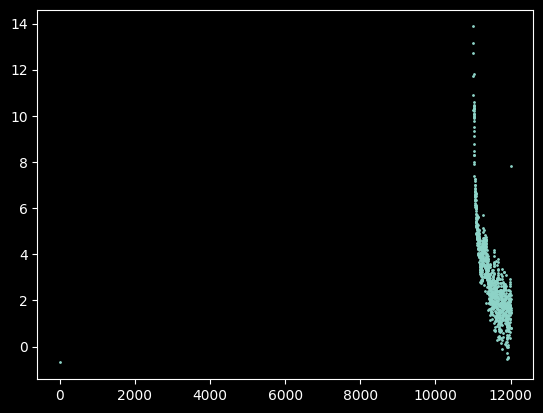

In [23]:
plt_pos = 4
print(torch.argmax(relevant_logits[plt_pos], dim=-1))
plt.scatter(range(relevant_logits[plt_pos].shape[1]), relevant_logits[plt_pos].cpu(), s=1)

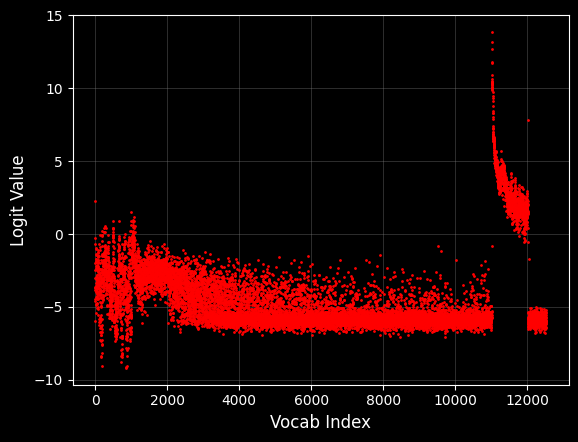

In [24]:
# plot raw logits
plt.scatter(range(raw_logits[plt_pos].shape[1]), raw_logits[plt_pos].cpu(), s=1, color='red')
plt.xlabel("Vocab Index", fontsize=12)
plt.ylabel("Logit Value", fontsize=12)
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# save the plot
plt.savefig(f'{parent_folder_path}/fig/sample_logits.pdf', bbox_inches='tight')

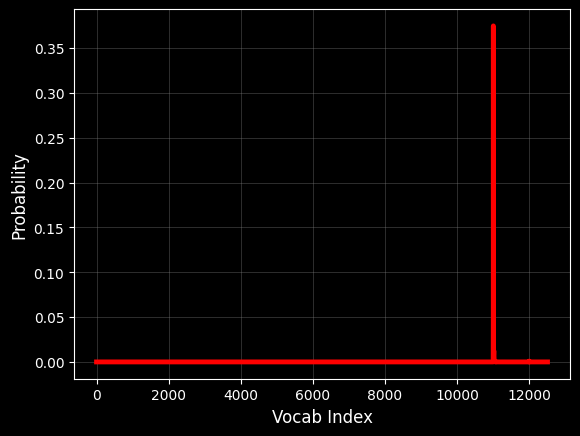

In [35]:
# F.softmax(raw_logits[plt_pos].cpu(), dim=-1)
plt.plot(range(raw_logits[plt_pos].shape[1]), F.softmax(raw_logits[plt_pos].cpu().flatten(), dim=-1), color='red', linewidth=3.5)
# plt.scatter(range(raw_logits[plt_pos].shape[1]), F.softmax(raw_logits[plt_pos].cpu(), dim=-1), s=2, color='red')
# plt.bar(range(raw_logits[plt_pos].shape[1]), F.softmax(raw_logits[plt_pos].cpu(), dim=-1), s=2, color='red')
plt.xlabel("Vocab Index", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# save the plot
plt.savefig(f'{parent_folder_path}/fig/sample_probs.pdf', bbox_inches='tight')

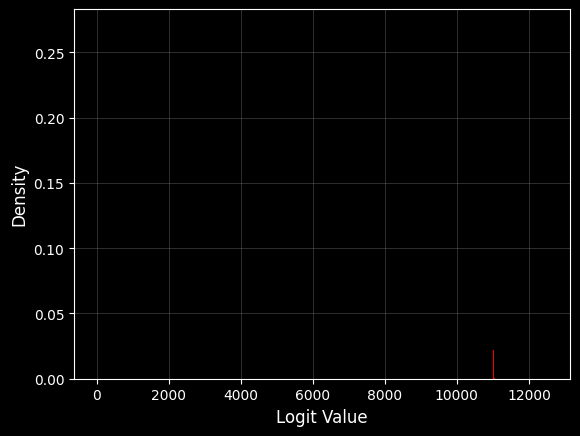

In [42]:
# plot the density of the logits
# plt.hist(raw_logits[plt_pos].cpu(), bins=100, color='red')
plt.bar(range(raw_logits[plt_pos].shape[1]), F.softmax(raw_logits[plt_pos].cpu().flatten(), dim=-1), color='red', width=1)
plt.xlabel("Vocab Index", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

In [38]:
F.softmax(raw_logits[plt_pos].cpu(), dim=-1).flatten()

tensor([5.2352e-10, 6.8366e-06, 1.2846e-07,  ..., 7.4570e-10, 5.4770e-10,
        5.2466e-10])

In [53]:
logits[:, 12049:12053]

tensor([[   -inf,    -inf, 28.8510,    -inf]], device='cuda:0',
       grad_fn=<SliceBackward0>)

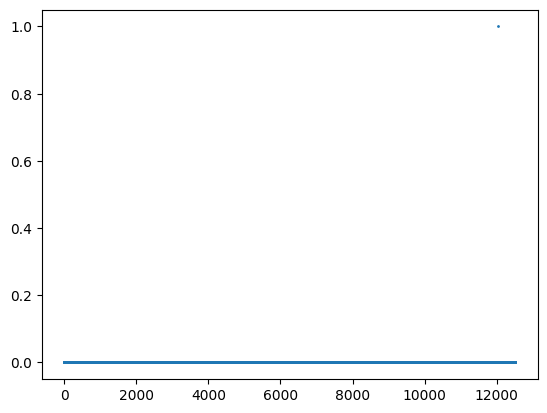

In [31]:
probs
probs.shape

# convert probs to numpy array and then plot a scatter plot of the values.
# x-axis is the index of the token, y-axis is the probability of that token
probs_np = np.array(probs[0].tolist())
probs_np.shape
plt.scatter(range(len(probs_np)), probs_np, s=1)

In [21]:
# vocab.ENCODING['ticker']

In [62]:
# print("logits:", logits)

# # First sort and calculate cumulative sum of probabilities.
# sorted_logits, sorted_indices = torch.sort(logits, descending=False)
# sorted_logits, sorted_indices
# cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
# cumulative_probs
# # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
# sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
# sorted_indices_to_remove
# # scatter sorted tensors to original indexing
# indices_to_remove = sorted_indices_to_remove.scatter(
#     1, sorted_indices, sorted_indices_to_remove
# )
# indices_to_remove
# logits.masked_fill_(indices_to_remove, float("-inf"))

logits: tensor([[-7.0298, -3.1519,  1.7736,  ..., -6.4578, -6.4962, -5.7820]],
       device='cuda:0', grad_fn=<SliceBackward0>)


tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0',
       grad_fn=<AsStridedBackward0>)

In [61]:
# print("logits:", logits)

# sorted_logits, sorted_indices = torch.sort(logits, descending=True)
# # print("sorted_logits.shape:", sorted_logits.shape)
# # print("sorted_indices.shape:", sorted_indices.shape)
# sorted_logits, sorted_indices
# cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
# # print("cumulative_probs.shape:", cumulative_probs.shape)
# cumulative_probs

# # Remove tokens with cumulative probability above the threshold
# sorted_indices_to_remove = cumulative_probs >= top_p
# # Shift the indices to the right to keep also the first token above the threshold
# sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
# sorted_indices_to_remove[..., 0] = 0

# # scatter sorted tensors to original indexing
# indices_to_remove1 = torch.zeros_like(logits, dtype=sorted_indices_to_remove.dtype).scatter_(
#     dim=-1, index=sorted_indices, src=sorted_indices_to_remove )
# indices_to_remove1
# # indices_to_remove2 = sorted_indices_to_remove.scatter(
# #     1, sorted_indices, sorted_indices_to_remove
# # )
# # indices_to_remove2[:, -20:]
# # logits[indices_to_remove1] = -float('Inf')
# # logits 

logits: tensor([[-7.0298, -3.1519,  1.7736,  ..., -6.4578, -6.4962, -5.7820]],
       device='cuda:0', grad_fn=<SliceBackward0>)
sorted_indices_to_remove.shape: torch.Size([1, 12515])


tensor([[True, True, True,  ..., True, True, True]], device='cuda:0')